# Библиотека:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transliterate


In [ ]:
import pandas as pd

In [ ]:
!pip install catboost

In [ ]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
# import category_encoders as ce
import numpy as np
from sklearn.compose import ColumnTransformer
import torchvision.transforms.v2 as T
import torchvision.models as models
from torch.utils.data import Dataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
import sympy
import pandas as pd

In [ ]:
import pickle
from catboost import CatBoostClassifier, Pool
#import optuna
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score,f1_score


# Начало

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/ранжирование мероприятий/Сводный перечень (1).xlsx', sheet_name='Датасет')

удаляю нулевую строку

In [ ]:
data = data.drop([0])

Удален "Суммарный балл по мероприятию" потому что не нужен

In [ ]:
data = data.drop(['Суммарный балл по мероприятию'], axis=1)
data = data.fillna(0)
data = data.astype({'СРОК РЕАЛИЗАЦИИ (начало)': 'int',
                'СРОК РЕАЛИЗАЦИИ (окончание)': 'int',
                  'Профинансировано': int})

<ipython-input-395-def01e6d8780>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.fillna(0)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
data.iloc[:, 5:-1 ] = scaler.fit_transform(data.iloc[:, 5:-1 ])

<ipython-input-398-3cdc5d184900>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 1. 1. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:, 5:-1 ] = scaler.fit_transform(data.iloc[:, 5:-1 ])


In [ ]:
data.head(1)

,Бассейновый округ,Наименование субъекта Российской Федерации,Наименование мероприятия,СРОК РЕАЛИЗАЦИИ (начало),СРОК РЕАЛИЗАЦИИ (окончание),"Базовые критерии (Водный объект находится в границах объекта (территории), включенного в реестр объектов культурного наследия (памятников истории и культуры) народов Российской Федерации, особо охраняемой природной территории, исторического центра, центра духовного просвещения и культуры населенного пункта, культового сооружения или является непосредственно объектом международного соглашения (меморандумов, договоров и пр.))","Базовые критерии (Мероприятие по расчистке участка водного объекта, используемого)\nв целях обеспечения питьевого и хозяйственно-бытового водоснабжения населения","Базовые критерии (Мероприятие по расчистке участка водного объекта, находящегося)\nв границах поселений и активно используемого населением \nв рекреационных целях","Дополнительные критерии (Мероприятие, синхронизированное с мероприятиями \nпо благоустройству территорий, финансируемыми из бюджета субъекта Российской Федерации и иных источников)",Дополнительные критерии Мероприятие по реализации нового этапа ранее начатого мероприятия на водном объекте (в случае наличия у мероприятия заключенного государственного контракта балл увеличивается в 2 раза)),...,"Дополнительные критерии (Мероприятие, включенное в долгосрочные планы комплексного социально-экономического развития городов Дальнего Востока)","Дополнительные критерии (Мероприятие, выполняемое на территории Арктической зоны Российской Федерации)","Дополнительные критерии (Мероприятие, выполняемое на участке водного объекта, находящегося на территории национального туристского маршрута)","Дополнительные критерии (Мероприятие, выполняемое в границах опорных населенных пунктов)","Дополнительные критерии (Мероприятие, для реализации которого предусмотрено финансирование за счет средств регионального бюджета и/или внебюджетных источников)","Дополнительные критерии (Наличие у субъекта Российской Федерации переносов сроков достижения показателей и (или) результатов реализации мероприятий)\nза последние три года реализации мероприятий федеральных проектов «Оздоровление Волги», «Сохранение уникальных водных объектов» национального проекта «Экология»",Показатели и единицы измерения (ПСД),"Показатели и единицы измерения (Протяженность расчищенных участков водных объектов, км)","Показатели и единицы измерения (Численность населения, для которого созданы комфортные условия проживания вблизи водных объектов, чел.)",Профинансировано
1,Уральский БО,Оренбургская область,Расчитка русла реки Урал на территории города ...,2025,2027,0,0,1,1,0.0,...,0,0,1,1,0,1,0.0,0.03625,0.183629,1


In [ ]:
data['Дополнительные критерии  (Наличие у субъекта Российской Федерации переносов сроков достижения показателей и (или) результатов реализации мероприятий)\nза последние три года реализации мероприятий федеральных проектов «Оздоровление Волги», «Сохранение уникальных водных объектов» национального проекта «Экология»'].value_counts()

,count
"Дополнительные критерии (Наличие у субъекта Российской Федерации переносов сроков достижения показателей и (или) результатов реализации мероприятий) за последние три года реализации мероприятий федеральных проектов «Оздоровление Волги», «Сохранение уникальных водных объектов» национального проекта «Экология»",
1,1241
0,46


In [ ]:
data['Профинансировано'].value_counts()

,count
Профинансировано,
0,1106
1,181


### из категорипльного в числовой формат перевожу столбцы

In [ ]:
data.dtypes

,0
Бассейновый округ,object
Наименование субъекта Российской Федерации,object
Наименование мероприятия,object
СРОК РЕАЛИЗАЦИИ (начало),int64
СРОК РЕАЛИЗАЦИИ (окончание),int64
"Базовые критерии (Водный объект находится в границах объекта (территории), включенного в реестр объектов культурного наследия (памятников истории и культуры) народов Российской Федерации, особо охраняемой природной территории, исторического центра, центра духовного просвещения и культуры населенного пункта, культового сооружения или является непосредственно объектом международного соглашения (меморандумов, договоров и пр.))",int64
"Базовые критерии (Мероприятие по расчистке участка водного объекта, используемого)\nв целях обеспечения питьевого и хозяйственно-бытового водоснабжения населения",int64
"Базовые критерии (Мероприятие по расчистке участка водного объекта, находящегося)\nв границах поселений и активно используемого населением \nв рекреационных целях",int64
"Дополнительные критерии (Мероприятие, синхронизированное с мероприятиями \nпо благоустройству территорий, финансируемыми из бюджета субъекта Российской Федерации и иных источников)",int64
Дополнительные критерии Мероприятие по реализации нового этапа ранее начатого мероприятия на водном объекте (в случае наличия у мероприятия заключенного государственного контракта балл увеличивается в 2 раза)),float64


In [ ]:
label_encoder = LabelEncoder()

In [ ]:
data['Бассейновый округ'] = label_encoder.fit_transform(data['Бассейновый округ'])

In [ ]:
data['Наименование субъекта Российской Федерации'] = label_encoder.fit_transform(data['Наименование субъекта Российской Федерации'])

In [ ]:
data['Наименование мероприятия'] = label_encoder.fit_transform(data['Наименование мероприятия'])

In [ ]:
data.dtypes

,0
Бассейновый округ,int64
Наименование субъекта Российской Федерации,int64
Наименование мероприятия,int64
СРОК РЕАЛИЗАЦИИ (начало),int64
СРОК РЕАЛИЗАЦИИ (окончание),int64
"Базовые критерии (Водный объект находится в границах объекта (территории), включенного в реестр объектов культурного наследия (памятников истории и культуры) народов Российской Федерации, особо охраняемой природной территории, исторического центра, центра духовного просвещения и культуры населенного пункта, культового сооружения или является непосредственно объектом международного соглашения (меморандумов, договоров и пр.))",int64
"Базовые критерии (Мероприятие по расчистке участка водного объекта, используемого)\nв целях обеспечения питьевого и хозяйственно-бытового водоснабжения населения",int64
"Базовые критерии (Мероприятие по расчистке участка водного объекта, находящегося)\nв границах поселений и активно используемого населением \nв рекреационных целях",int64
"Дополнительные критерии (Мероприятие, синхронизированное с мероприятиями \nпо благоустройству территорий, финансируемыми из бюджета субъекта Российской Федерации и иных источников)",int64
Дополнительные критерии Мероприятие по реализации нового этапа ранее начатого мероприятия на водном объекте (в случае наличия у мероприятия заключенного государственного контракта балл увеличивается в 2 раза)),float64


In [ ]:
data.isna().sum()

,0
Бассейновый округ,0
Наименование субъекта Российской Федерации,0
Наименование мероприятия,0
СРОК РЕАЛИЗАЦИИ (начало),0
СРОК РЕАЛИЗАЦИИ (окончание),0
"Базовые критерии (Водный объект находится в границах объекта (территории), включенного в реестр объектов культурного наследия (памятников истории и культуры) народов Российской Федерации, особо охраняемой природной территории, исторического центра, центра духовного просвещения и культуры населенного пункта, культового сооружения или является непосредственно объектом международного соглашения (меморандумов, договоров и пр.))",0
"Базовые критерии (Мероприятие по расчистке участка водного объекта, используемого)\nв целях обеспечения питьевого и хозяйственно-бытового водоснабжения населения",0
"Базовые критерии (Мероприятие по расчистке участка водного объекта, находящегося)\nв границах поселений и активно используемого населением \nв рекреационных целях",0
"Дополнительные критерии (Мероприятие, синхронизированное с мероприятиями \nпо благоустройству территорий, финансируемыми из бюджета субъекта Российской Федерации и иных источников)",0
Дополнительные критерии Мероприятие по реализации нового этапа ранее начатого мероприятия на водном объекте (в случае наличия у мероприятия заключенного государственного контракта балл увеличивается в 2 раза)),0


### Проверка выбросов

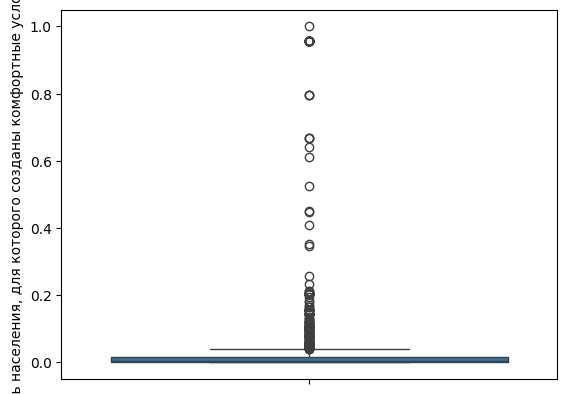

In [ ]:
import seaborn as sns
sns.boxplot(data['Показатели и единицы измерения  (Численность населения, для которого созданы комфортные условия проживания вблизи водных объектов, чел.)'])
plt.show()

обработка выбросов, с помощью логарифмирования

In [ ]:
data['Показатели и единицы измерения  (Численность населения, для которого созданы комфортные условия проживания вблизи водных объектов, чел.)'] = np.log1p(data['Показатели и единицы измерения  (Численность населения, для которого созданы комфортные условия проживания вблизи водных объектов, чел.)'])

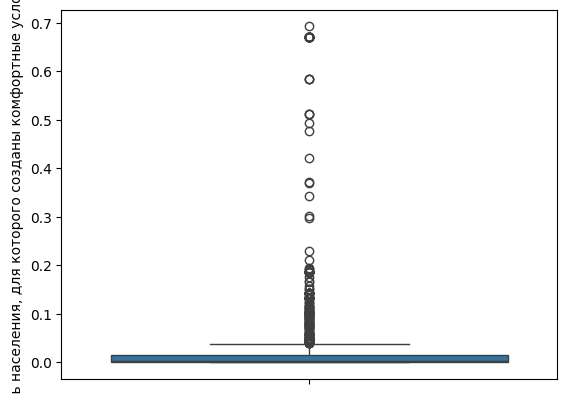

In [ ]:
import seaborn as sns
sns.boxplot(data['Показатели и единицы измерения  (Численность населения, для которого созданы комфортные условия проживания вблизи водных объектов, чел.)'])
plt.show()

### смотрю корреляцию:

In [ ]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,Бассейновый округ,Наименование субъекта Российской Федерации,Наименование мероприятия,СРОК РЕАЛИЗАЦИИ (начало),СРОК РЕАЛИЗАЦИИ (окончание),"Базовые критерии (Водный объект находится в границах объекта (территории), включенного в реестр объектов культурного наследия (памятников истории и культуры) народов Российской Федерации, особо охраняемой природной территории, исторического центра, центра духовного просвещения и культуры населенного пункта, культового сооружения или является непосредственно объектом международного соглашения (меморандумов, договоров и пр.))","Базовые критерии (Мероприятие по расчистке участка водного объекта, используемого) в целях обеспечения питьевого и хозяйственно-бытового водоснабжения населения","Базовые критерии (Мероприятие по расчистке участка водного объекта, находящегося) в границах поселений и активно используемого населением в рекреационных целях","Дополнительные критерии (Мероприятие, синхронизированное с мероприятиями по благоустройству территорий, финансируемыми из бюджета субъекта Российской Федерации и иных источников)",Дополнительные критерии Мероприятие по реализации нового этапа ранее начатого мероприятия на водном объекте (в случае наличия у мероприятия заключенного государственного контракта балл увеличивается в 2 раза)),"Дополнительные критерии (Мероприятие, для которого разработана проектная документация за счет средств субвенций в рамках переданных полномочий Российской Федерации, в том числе в рамках федеральных проектов «Сохранение уникальных водных объектов», «Оздоровление Волги»)","Дополнительные критерии (Мероприятие, финансирование которого запланировано Федеральным законом от 27.11.2023 № 540-ФЗ «О федеральном бюджете на 2024 год и на плановый период 2025 и 2026 годов»)","Мероприятие по расчистке участка водного объекта, необходимость реализации которого указана в поручении Президента Российской Федерации","Мероприятие по расчистке участка водного объекта, целесообразность реализации которого рекомендована постановлениями Совета Федерации Федерального Собрания РФ, Государственной Думы Федерального Собрания РФ, а также мероприятие по расчистке участка водного объекта, указанное в Послании Президента Российской Федерации Федеральному Собранию и поручениях Правительства Российской Федерации","Дополнительные критерии (Мероприятие по расчистке участка водного объекта, необходимость реализации которого предусмотрена нормативными правовыми актами Правительства Российской Федерации)","Дополнительные критерии (Мероприятие, выполняемое на территориях субъектов Российской Федерации, принятых в состав Российской Федерации в соответствии с федеральными конституционными законами от 21.03.2014 № 6-ФКЗ, от 04.10.2022 № 5-ФКЗ, от 04.10.2022 № 6-ФКЗ, от 04.10.2022 № 7-ФКЗ, от 04.10.2022 № 8-ФКЗ)","Дополнительные критерии (Мероприятие, включенное в долгосрочные планы комплексного социально-экономического развития городов Дальнего Востока)","Дополнительные критерии (Мероприятие, выполняемое на территории Арктической зоны Российской Федерации)","Дополнительные критерии (Мероприятие, выполняемое на участке водного объекта, находящегося на территории национального туристского маршрута)","Дополнительные критерии (Мероприятие, выполняемое в границах опорных населенных пунктов)","Дополнительные критерии (Мероприятие, для реализации которого предусмотрено финансирование за счет средств регионального бюджета и/или внебюджетных источников)","Дополнительные критерии (Наличие у субъекта Российской Федерации переносов сроков достижения показателей и (или) результатов реализации мероприятий) за последние три года реализации мероприятий федеральных проектов «Оздоровление Волги», «Сохранение уникальных водных объектов» национального проекта «Экология»",Показатели и единицы измерения (ПСД),"Показатели и единицы измерения (Протяженность расчищенных участков водных объектов, км)","Показатели и единицы измерения (Численность населения, для которого созданы комфортные условия проживания вблизи водных объектов, ч

In [ ]:
data = data.drop(columns = ['Наименование мероприятия'])

# **Обработка дисбаланса классов**
Дисбаланс классов (86% класс 0, 14% класс 1) может привести к тому, что модель\ будет склонна предсказывать мажоритарный класс (0), игнорируя миноритарный (1).

In [ ]:
X = data.drop('Профинансировано', axis=1)
y = data['Профинансировано']

In [ ]:
y.value_counts()

,count
Профинансировано,
0,1106
1,181


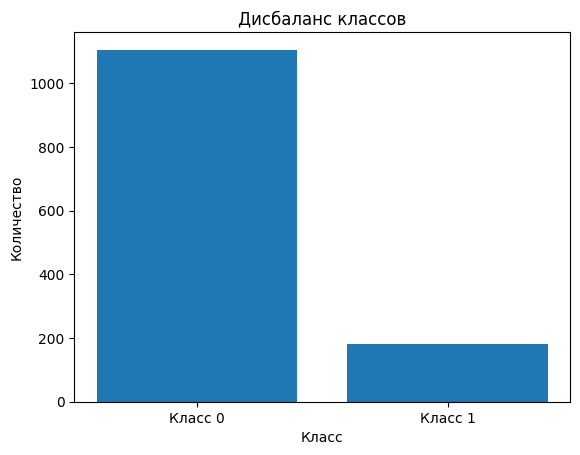

In [ ]:
count_class = y.value_counts()
plt.bar(count_class.index, count_class.values)
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.title('Дисбаланс классов')
plt.xticks(count_class.index, ['Класс 0', 'Класс 1'])
plt.show()

In [ ]:
X.shape, y.shape

((1287, 24), (1287,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced= smote.fit_resample(X_train, y_train)

In [ ]:
X_train.shape, y_train.shape

((900, 24), (900,))

In [ ]:
y_train.value_counts()

,count
Профинансировано,
0,773
1,127


In [ ]:
X_train_balanced.shape, y_train_balanced.shape

((1546, 24), (1546,))

In [ ]:
y_train_balanced.value_counts()

,count
Профинансировано,
0,773
1,773


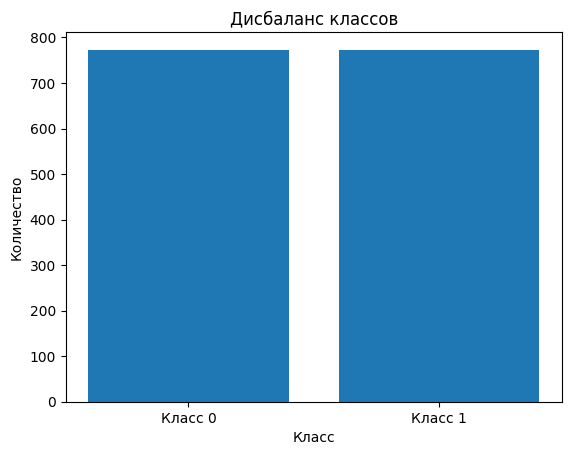

In [ ]:
count_class = y_train_balanced.value_counts()
plt.bar(count_class.index, count_class.values)
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.title('Дисбаланс классов')
plt.xticks(count_class.index, ['Класс 0', 'Класс 1'])
plt.show()

In [ ]:
y_test.value_counts()

,count
Профинансировано,
0,333
1,54


In [ ]:
from transliterate import translit

In [ ]:
def clean_and_transliterate_column_names(df):
    column_mapping = {}
    for col in df.columns:
        # Очистка специальных символов
        clean_col = col.replace('\n', '_').replace(' ', '_').replace(',', '_').replace('(', '').replace(')', '').replace('__', '_').strip()
        # Транслитерация кириллицы в латиницу
        translit_col = translit(clean_col, 'ru', reversed=True)
        column_mapping[col] = translit_col
    df.rename(columns=column_mapping, inplace=True)
    return df

# Применение
data = clean_and_transliterate_column_names(data)
X_train_balanced = clean_and_transliterate_column_names(X_train_balanced)
X_test = clean_and_transliterate_column_names(X_test)

# Проверка новых имен столбцов
print(X_train_balanced.columns)

Index(['Bassejnovyj_okrug', 'Naimenovanie_sub'ekta_Rossijskoj_Federatsii',
       'SROK_REALIZATsII_nachalo', 'SROK_REALIZATsII_okonchanie',
       'Bazovye_kriterii_Vodnyj_ob'ekt_nahoditsja_v_granitsah_ob'ekta_territorii_vkljuchennogo_v_reestr_ob'ektov_kul'turnogo_nasledija_pamjatnikov_istorii_i_kul'tury_narodov_Rossijskoj_Federatsii_osobo_ohranjaemoj_prirodnoj_territorii_istoricheskogo_tsentra_tsentra_duhovnogo_prosveschenija_i_kul'tury_naselennogo_punkta_kul'tovogo_sooruzhenija_ili_javljaetsja_neposredstvenno_ob'ektom_mezhdunarodnogo_soglashenija_memorandumov_dogovorov_i_pr.',
       'Bazovye_kriterii_Meroprijatie_po_raschistke_uchastka_vodnogo_ob'ekta_ispol'zuemogo_v_tseljah_obespechenija_pit'evogo_i_hozjajstvenno-bytovogo_vodosnabzhenija_naselenija',
       'Bazovye_kriterii_Meroprijatie_po_raschistke_uchastka_vodnogo_ob'ekta_nahodjaschegosja_v_granitsah_poselenij_i_aktivno_ispol'zuemogo_naseleniem_v_rekreatsionnyh_tseljah',
       'Dopolnitel'nye_kriterii_Meroprijatie_sinhronizir

# Шаг 2: Проверка статистических аспектов
## 2.1 Проверка мультиколлинеарности
Высокая корреляция между признаками может ухудшить производительность линейных моделей и интерпретируемость. \
 Variance Inflation Factor (VIF) для оценки мультиколлинеарности.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_numeric = X_train_balanced.select_dtypes(include=['float64', 'int64'])

# Проверка VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
print(vif_data)

# Удаление признаков с VIF > 10
high_vif = vif_data[vif_data['VIF'] > 10]['Feature'].tolist()
X_train_balanced = X_train_balanced.drop(high_vif, axis=1)
X_test = X_test.drop(high_vif, axis=1)

                                              Feature           VIF
0                                   Bassejnovyj_okrug  5.371005e+00
1         Naimenovanie_sub'ekta_Rossijskoj_Federatsii  4.356636e+00
2                            SROK_REALIZATsII_nachalo  8.957017e+06
3                         SROK_REALIZATsII_okonchanie  8.960310e+06
4   Bazovye_kriterii_Vodnyj_ob'ekt_nahoditsja_v_gr...  2.111060e+00
5   Bazovye_kriterii_Meroprijatie_po_raschistke_uc...  2.541364e+00
6   Bazovye_kriterii_Meroprijatie_po_raschistke_uc...  1.095554e+01
7   Dopolnitel'nye_kriterii_Meroprijatie_sinhroniz...  1.451282e+00
8   Dopolnitel'nye_kriterii_Meroprijatie_po_realiz...  1.809875e+00
9   Dopolnitel'nye_kriterii_Meroprijatie_dlja_koto...  1.329632e+00
10  Dopolnitel'nye_kriterii_Meroprijatie_finansiro...  1.718143e+00
11  Meroprijatie_po_raschistke_uchastka_vodnogo_ob...  1.195431e+00
12  Meroprijatie_po_raschistke_uchastka_vodnogo_ob...  1.726783e+00
13  Dopolnitel'nye_kriterii_Meroprijatie_po_rasc

# 2.3 Анализ остатков (для интерпретируемых моделей)
Зачем? Для логистической регрессии анализ остатков помогает понять, где модель ошибается.
Что делать? Постройте Q-Q plot для остатков.

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


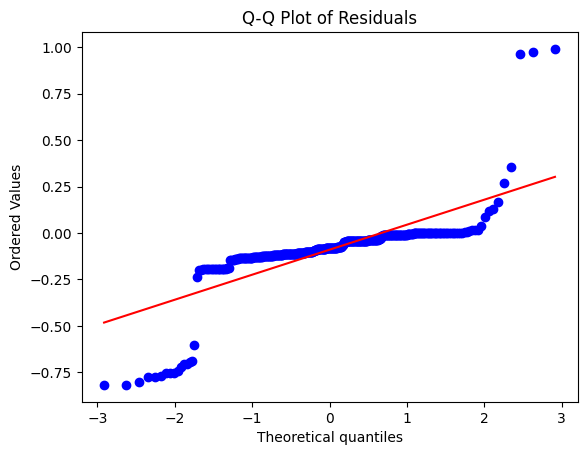

In [ ]:
from scipy.stats import probplot
from sklearn.linear_model import LogisticRegression

# Обучение логистической регрессии
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_balanced, y_train_balanced)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Остатки
residuals = y_test - y_pred_proba
probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# 2.4 Проверка гетероскедастичности
Зачем? Хотя гетероскедастичность чаще проверяется в регрессии, в классификации можно анализировать вариацию предсказанных вероятностей.
Что делать? Постройте график предсказанных вероятностей против остатков.

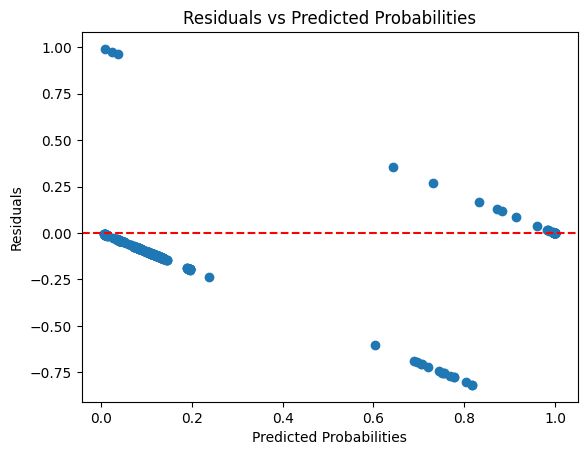

In [ ]:
plt.scatter(y_pred_proba, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Probabilities')
plt.show()

# Шаг 3: Реализация методов машинного обучения

## 3.1 Логистическая регрессия (с class_weight)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(class_weight='balanced', random_state=42)
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_balanced, y_train_balanced)
best_logreg = grid_search.best_estimator_
print("Лучшие параметры логистической регрессии:", grid_search.best_params_)

Лучшие параметры логистической регрессии: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
y_pred = grid_search.predict(X_test)
print("Первые 5 предсказаний:", y_pred[:5])
print("Первые 5 истинных меток:", y_test[:5].values)
print("Совпадение:", (y_pred == y_test).mean())  # Должно быть < 1.0 для реальной модели

Первые 5 предсказаний: [0 0 0 0 0]
Первые 5 истинных меток: [0 0 0 0 0]
Совпадение: 0.9638242894056848


## 3.2 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train_balanced, y_train_balanced)
best_rf = grid_search_rf.best_estimator_
print("Лучшие параметры Random Forest:", grid_search_rf.best_params_)

Лучшие параметры Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
y_pred = grid_search_rf.predict(X_test)
print("Первые 5 предсказаний:", y_pred[:5])
print("Первые 5 истинных меток:", y_test[:5].values)
print("Совпадение:", (y_pred == y_test).mean())

Первые 5 предсказаний: [0 0 0 0 0]
Первые 5 истинных меток: [0 0 0 0 0]
Совпадение: 0.9767441860465116


## 3.3 XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]}
grid_search_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_xgb.fit(X_train_balanced, y_train_balanced)
best_xgb = grid_search_xgb.best_estimator_
print("Лучшие параметры XGBoost:", grid_search_xgb.best_params_)

Лучшие параметры XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [ ]:
y_pred = grid_search_xgb.predict(X_test)
print("Первые 5 предсказаний:", y_pred[:5])
print("Первые 5 истинных меток:", y_test[:5].values)
print("Совпадение:", (y_pred == y_test).mean())

Первые 5 предсказаний: [0 0 0 0 0]
Первые 5 истинных меток: [0 0 0 0 0]
Совпадение: 0.9741602067183462


## 3.4 LightGBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Инициализация модели
lgbm = LGBMClassifier(random_state=42)

# Определение сетки гиперпараметров
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

# GridSearchCV
grid_search_lgbm = GridSearchCV(lgbm, param_grid, cv=5, scoring='f1', n_jobs=-1, error_score='raise')
grid_search_lgbm.fit(X_train_balanced, y_train_balanced)

# Вывод лучших параметров
best_lgbm = grid_search_lgbm.best_estimator_
print("Лучшие параметры LightGBM:", grid_search_lgbm.best_params_)

[LightGBM] [Info] Number of positive: 773, number of negative: 773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 1546, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [ ]:
y_pred = grid_search_lgbm.predict(X_test)
print("Первые 5 предсказаний:", y_pred[:5])
print("Первые 5 истинных меток:", y_test[:5].values)
print("Совпадение:", (y_pred == y_test).mean())

Первые 5 предсказаний: [0 0 0 0 0]
Первые 5 истинных меток: [0 0 0 0 0]
Совпадение: 0.979328165374677


## 3.5 SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV

# Определение модели LinearSVC с калибровкой для вероятностей
svm = CalibratedClassifierCV(LinearSVC(random_state=42, max_iter=1000), cv=5)

# Сетка гиперпараметров
param_grid = {'estimator__C': [0.01, 0.1, 1.0, 10.0]}

# Настройка GridSearchCV
grid_search_svm = GridSearchCV(svm, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Обучение на сбалансированных данных
grid_search_svm.fit(X_train_balanced, y_train_balanced)

# Получение лучшей модели
best_svm = grid_search_svm.best_estimator_

# Вывод лучших параметров
print("Лучшие параметры SVM:", grid_search_svm.best_params_)

Лучшие параметры SVM: {'estimator__C': 10.0}


## 3.6 Stacking (ансамбль)

In [ ]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('rf', best_rf),
    # ('xgb', best_xgb),
    ('lgbm', best_lgbm)
]
stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking.fit(X_train_balanced, y_train_balanced)

[LightGBM] [Info] Number of positive: 773, number of negative: 773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 1546, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('lgbm',
                                LGBMClassifier(max_depth=5, n_estimators=200,
                                               random_state=42))],
                   final_estimator=LogisticRegression())

## 3.7 Baseline модель

In [ ]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train_balanced, y_train_balanced)

DummyClassifier(random_state=42, strategy='most_frequent')

## 3.8 CatBoost

In [ ]:
cat_features = X_train_balanced.select_dtypes(include=['object']).columns.tolist()
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

model1 = CatBoostClassifier(
    iterations=500,  # Количество деревьев
    learning_rate=0.05,  # Скорость обучения
    depth=6,  # Глубина деревьев
    loss_function='Logloss',  # Для бинарной классификации
    eval_metric='AUC',  # Оцениваем AUC
    verbose=100,  # Вывод логов каждые 100 итераций
    l2_leaf_reg=3,  # L2 регуляризация
    random_strength = 1,  # Добавляет случайность в процесс построения деревьев
    bagging_temperature=1,  # Добавляет случайность при выборке подвыборок
    scale_pos_weight=scale_pos_weight,  # Учитываем дисбаланс
    cat_features=cat_features,  # Категориальные признаки
)

# Обучаем модель
model1.fit(X_train_balanced, y_train_balanced, early_stopping_rounds=20)

0:	total: 3.45ms	remaining: 1.72s
100:	total: 322ms	remaining: 1.27s
200:	total: 654ms	remaining: 972ms
300:	total: 929ms	remaining: 614ms
400:	total: 1.16s	remaining: 287ms
499:	total: 1.41s	remaining: 0us


In [ ]:
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(model, X, y, cv=5, scoring='f1')
# print(f'Cross-validated F1: {scores.mean():.3f} ± {scores.std():.3f}')

## 3.9 CatBoost2

In [ ]:
data2 = pd.read_excel('/content/drive/MyDrive/ранжирование мероприятий/Сводный перечень (1).xlsx', sheet_name='Датасет')

удаляю нулевую строку

In [ ]:
data2 = data2.drop([0])

Удален "Суммарный балл по мероприятию" потому что не нужен

In [ ]:
data2 = data2.drop(['Суммарный балл по мероприятию'], axis=1)
data2 = data2.fillna(0)
data2 = data2.astype({'СРОК РЕАЛИЗАЦИИ (начало)': 'int',
                'СРОК РЕАЛИЗАЦИИ (окончание)': 'int',
                  'Профинансировано': int})

<ipython-input-348-8392742b5bcf>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data2 = data2.fillna(0)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
data2.iloc[:, 5:-1 ] = scaler.fit_transform(data2.iloc[:, 5:-1 ])

<ipython-input-351-1cfc0c288ece>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 1. 1. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data2.iloc[:, 5:-1 ] = scaler.fit_transform(data2.iloc[:, 5:-1 ])


In [ ]:
data2['Показатели и единицы измерения  (Численность населения, для которого созданы комфортные условия проживания вблизи водных объектов, чел.)'] = np.log1p(data2['Показатели и единицы измерения  (Численность населения, для которого созданы комфортные условия проживания вблизи водных объектов, чел.)'])

In [ ]:
data2 = data2.drop(columns = ['Наименование мероприятия'])

In [ ]:
X2 = data2.drop('Профинансировано', axis=1)
y2 = data2['Профинансировано']

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.3, stratify=y2, random_state=42)

In [ ]:
cat_features2 = X_train2.select_dtypes(include=['object']).columns.tolist()
scale_pos_weight2 = (y2 == 0).sum() / (y2 == 1).sum()

model2 = CatBoostClassifier(
    iterations=500,  # Количество деревьев
    learning_rate=0.05,  # Скорость обучения
    depth=6,  # Глубина деревьев
    loss_function='Logloss',  # Для бинарной классификации
    eval_metric='AUC',  # Оцениваем AUC
    verbose=100,  # Вывод логов каждые 100 итераций
    l2_leaf_reg=3,  # L2 регуляризация
    random_strength = 1,  # Добавляет случайность в процесс построения деревьев
    bagging_temperature=1,  # Добавляет случайность при выборке подвыборок
    scale_pos_weight=scale_pos_weight2,  # Учитываем дисбаланс
    cat_features=cat_features2,  # Категориальные признаки
)

# Обучаем модель
model2.fit(X_train2, y_train2, early_stopping_rounds=15)

0:	total: 5.13ms	remaining: 2.56s
100:	total: 442ms	remaining: 1.75s
200:	total: 906ms	remaining: 1.35s
300:	total: 1.31s	remaining: 869ms
400:	total: 2.2s	remaining: 543ms
499:	total: 3.05s	remaining: 0us


# Шаг 4: Оценка моделей с дополнительными метриками
4.1 Реализация метрик
Используйте accuracy, precision, recall, f1, roc_auc, а также добавьте:
Precision-Recall AUC
Matthews Correlation Coefficient (MCC)
Balanced Accuracy

НОВОЕ:


Logistic Regression Results:
Accuracy: 0.9638
Precision: 0.8226
Recall: 0.9444
F1 Score: 0.8793
Balanced Accuracy: 0.9557
MCC: 0.8610
ROC-AUC: 0.9550
Precision-Recall AUC: 0.9535

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       333
           1       0.82      0.94      0.88        54

    accuracy                           0.96       387
   macro avg       0.91      0.96      0.93       387
weighted avg       0.97      0.96      0.96       387



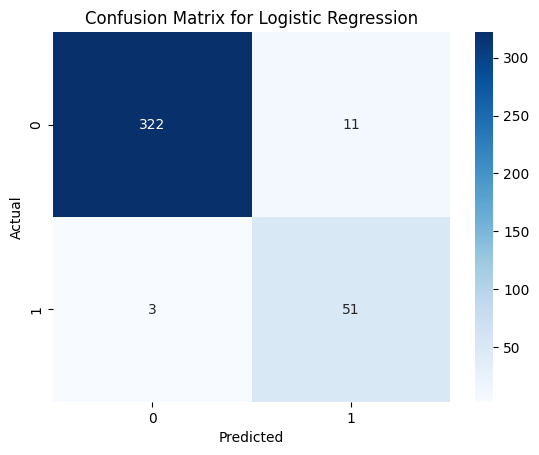


Random Forest Results:
Accuracy: 0.9767
Precision: 0.9091
Recall: 0.9259
F1 Score: 0.9174
Balanced Accuracy: 0.9555
MCC: 0.9040
ROC-AUC: 0.9957
Precision-Recall AUC: 0.9796

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       333
           1       0.91      0.93      0.92        54

    accuracy                           0.98       387
   macro avg       0.95      0.96      0.95       387
weighted avg       0.98      0.98      0.98       387



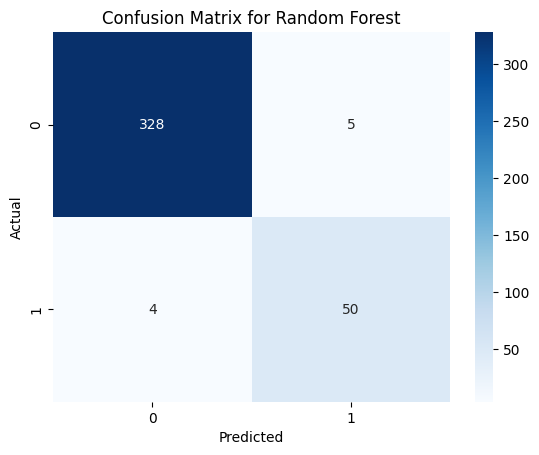


XGBoost Results:
Accuracy: 0.9742
Precision: 0.9074
Recall: 0.9074
F1 Score: 0.9074
Balanced Accuracy: 0.9462
MCC: 0.8924
ROC-AUC: 0.9711
Precision-Recall AUC: 0.9446

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       333
           1       0.91      0.91      0.91        54

    accuracy                           0.97       387
   macro avg       0.95      0.95      0.95       387
weighted avg       0.97      0.97      0.97       387



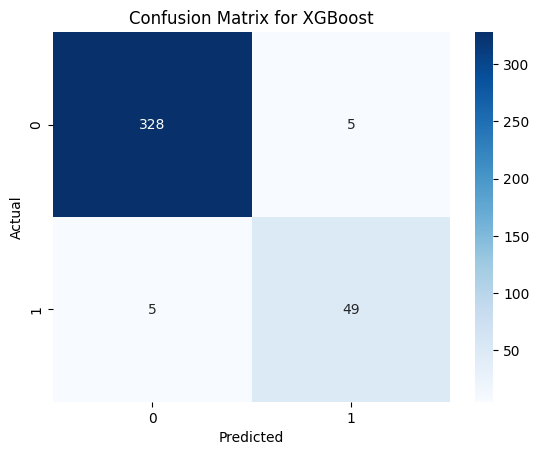


LightGBM Results:
Accuracy: 0.9793
Precision: 0.9423
Recall: 0.9074
F1 Score: 0.9245
Balanced Accuracy: 0.9492
MCC: 0.9128
ROC-AUC: 0.9735
Precision-Recall AUC: 0.9530

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       333
           1       0.94      0.91      0.92        54

    accuracy                           0.98       387
   macro avg       0.96      0.95      0.96       387
weighted avg       0.98      0.98      0.98       387



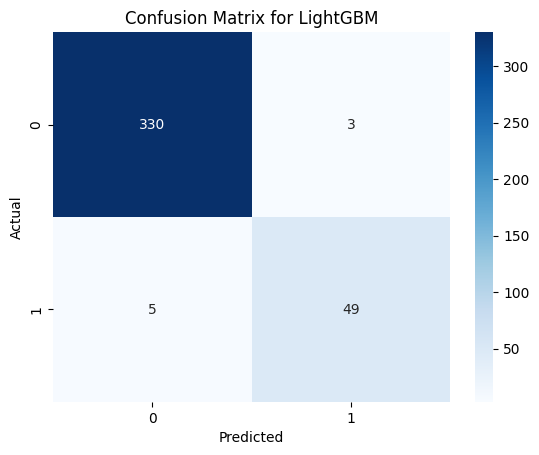


SVM Results:
Accuracy: 0.9638
Precision: 0.8226
Recall: 0.9444
F1 Score: 0.8793
Balanced Accuracy: 0.9557
MCC: 0.8610
ROC-AUC: 0.9611
Precision-Recall AUC: 0.9549

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       333
           1       0.82      0.94      0.88        54

    accuracy                           0.96       387
   macro avg       0.91      0.96      0.93       387
weighted avg       0.97      0.96      0.96       387



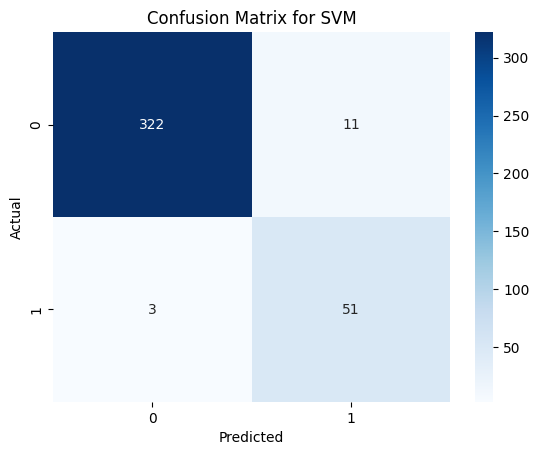


Stacking Results:
Accuracy: 0.9793
Precision: 0.9423
Recall: 0.9074
F1 Score: 0.9245
Balanced Accuracy: 0.9492
MCC: 0.9128
ROC-AUC: 0.9958
Precision-Recall AUC: 0.9796

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       333
           1       0.94      0.91      0.92        54

    accuracy                           0.98       387
   macro avg       0.96      0.95      0.96       387
weighted avg       0.98      0.98      0.98       387



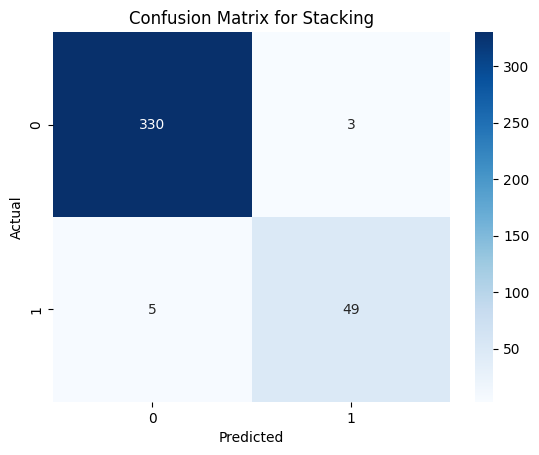

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_


Dummy Baseline Results:
Accuracy: 0.8605
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Balanced Accuracy: 0.5000
MCC: 0.0000
ROC-AUC: 0.5000
Precision-Recall AUC: 0.5698

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       333
           1       0.00      0.00      0.00        54

    accuracy                           0.86       387
   macro avg       0.43      0.50      0.46       387
weighted avg       0.74      0.86      0.80       387



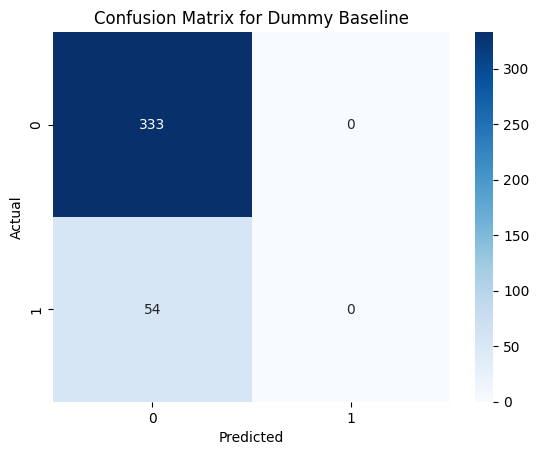


CatBoost Results:
Accuracy: 0.9612
Precision: 0.8305
Recall: 0.9074
F1 Score: 0.8673
Balanced Accuracy: 0.9387
MCC: 0.8458
ROC-AUC: 0.9865
Precision-Recall AUC: 0.9541

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       333
           1       0.83      0.91      0.87        54

    accuracy                           0.96       387
   macro avg       0.91      0.94      0.92       387
weighted avg       0.96      0.96      0.96       387



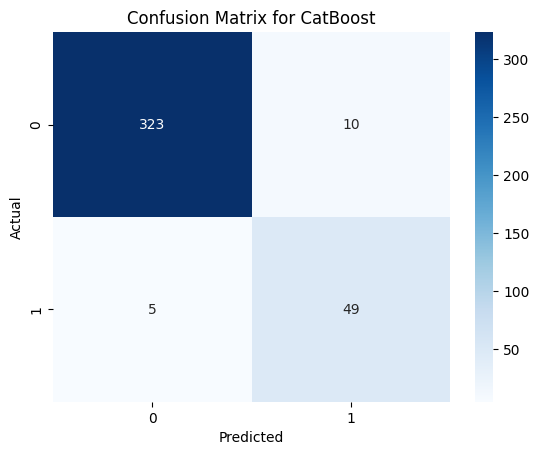


CatBoost_without_cleaning_data Results:
Accuracy: 0.9897
Precision: 1.0000
Recall: 0.9259
F1 Score: 0.9615
Balanced Accuracy: 0.9630
MCC: 0.9565
ROC-AUC: 0.9723
Precision-Recall AUC: 0.9615

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       333
           1       1.00      0.93      0.96        54

    accuracy                           0.99       387
   macro avg       0.99      0.96      0.98       387
weighted avg       0.99      0.99      0.99       387



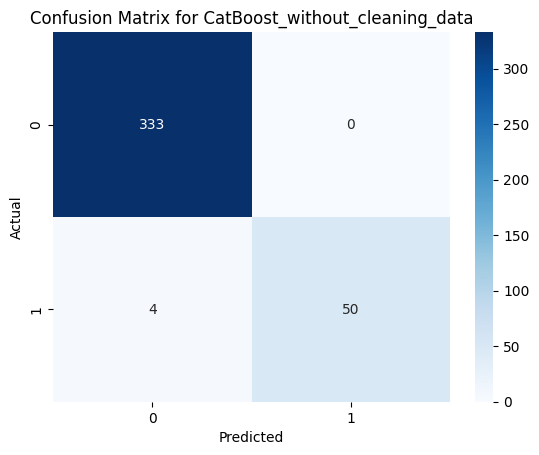


Сравнение моделей:
                            Model  Accuracy  Precision    Recall        F1  \
0             Logistic Regression  0.963824   0.822581  0.944444  0.879310   
1                   Random Forest  0.976744   0.909091  0.925926  0.917431   
2                         XGBoost  0.974160   0.907407  0.907407  0.907407   
3                        LightGBM  0.979328   0.942308  0.907407  0.924528   
4                             SVM  0.963824   0.822581  0.944444  0.879310   
5                        Stacking  0.979328   0.942308  0.907407  0.924528   
6                  Dummy Baseline  0.860465   0.000000  0.000000  0.000000   
7                        CatBoost  0.961240   0.830508  0.907407  0.867257   
8  CatBoost_without_cleaning_data  0.989664   1.000000  0.925926  0.961538   

   Balanced Accuracy       MCC   ROC-AUC    PR-AUC  
0           0.955706  0.860986  0.954955  0.953516  
1           0.955455  0.903950  0.995690  0.979641  
2           0.946196  0.892392  0.971138

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, matthews_corrcoef, balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def align_feature_names(X, model):
    """
    Приводит имена признаков в X к тем, что были при обучении модели.
    Возвращает выровненный DataFrame или массив.
    """
    if hasattr(model, 'feature_names_in_'):  # Для моделей scikit-learn
        expected_features = model.feature_names_in_
    elif hasattr(model, 'feature_names_'):  # Для некоторых моделей
        expected_features = model.feature_names_
    else:
        raise ValueError("Модель не предоставляет информацию о названиях признаков.")

    # Если X - DataFrame
    if isinstance(X, pd.DataFrame):
        current_features = X.columns
        # Проверяем, совпадают ли имена
        missing_features = set(expected_features) - set(current_features)
        extra_features = set(current_features) - set(expected_features)

        if missing_features or extra_features:
            print(f"Для модели {model.__class__.__name__}:")
            if missing_features:
                print(f"Отсутствующие признаки: {missing_features}")
            if extra_features:
                print(f"Лишние признаки: {extra_features}")
            # Удаляем лишние признаки и добавляем отсутствующие (заполняем нулями)
            X_aligned = X.reindex(columns=expected_features, fill_value=0)
        else:
            X_aligned = X
    else:  # Если X - numpy массив
        if X.shape[1] != len(expected_features):
            raise ValueError("Количество признаков не совпадает с обучением.")
        X_aligned = X

    return X_aligned

def evaluate_model(model, X_test, y_test, model_name):
    # Приведение имён признаков к тем, что были при обучении
    X_test_aligned = align_feature_names(X_test, model)

    # Проверка на соответствие размеров
    if len(X_test_aligned) != len(y_test):
        raise ValueError(f"Inconsistent number of samples for {model_name}: X_test ({len(X_test_aligned)}) vs y_test ({len(y_test)})")

    # Предсказания на тестовой выборке
    y_pred = model.predict(X_test_aligned)
    y_pred_proba = model.predict_proba(X_test_aligned)[:, 1] if hasattr(model, 'predict_proba') else None

    # Основные метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # ROC-AUC и PR-AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba) if y_pred_proba is not None else (None, None, None)
    pr_auc = auc(recall_vals, precision_vals) if y_pred_proba is not None else None

    # Вывод результатов
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"MCC: {mcc:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc:.4f}")
        print(f"Precision-Recall AUC: {pr_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Balanced Accuracy': balanced_acc,
        'MCC': mcc,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc
    }

# Оценка всех моделей с возможностью разных X_test, y_train и y_test
results = []
models_data = {
    'Logistic Regression': {'model': best_logreg, 'X_test': X_test, 'y_test': y_test},
    'Random Forest': {'model': best_rf, 'X_test': X_test, 'y_test': y_test},
    'XGBoost': {'model': best_xgb, 'X_test': X_test, 'y_test': y_test},
    'LightGBM': {'model': best_lgbm, 'X_test': X_test, 'y_test': y_test},
    'SVM': {'model': best_svm, 'X_test': X_test, 'y_test': y_test},
    'Stacking': {'model': stacking, 'X_test': X_test, 'y_test': y_test},
    'Dummy Baseline': {'model': dummy, 'X_test': X_test, 'y_test': y_test},
    'CatBoost': {'model': model, 'X_test': X_test, 'y_test': y_test},
    # Модель с другим X_test и y_test
    'CatBoost_without_cleaning_data': {'model': model2, 'X_test': X_test2, 'y_test': y_test2}
}

for name, data in models_data.items():
    result = evaluate_model(data['model'], data['X_test'], data['y_test'], name)
    results.append(result)

# Сохранение результатов
results_df = pd.DataFrame(results)
results_df.to_csv('model_comparison.csv', index=False)
print("\nСравнение моделей:")
print(results_df)

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'Balanced Accuracy', 'MCC', 'ROC-AUC', 'PR-AUC']]
results_df = results_df.round(4)
results_df.to_csv('model_comparison.csv', index=False)

In [ ]:
results_df

,Model,Accuracy,Precision,Recall,F1,Balanced Accuracy,MCC,ROC-AUC,PR-AUC
0,Logistic Regression,0.9638,0.8226,0.9444,0.8793,0.9557,0.8610,0.9550,0.9535
1,Random Forest,0.9767,0.9091,0.9259,0.9174,0.9555,0.9040,0.9957,0.9796
2,XGBoost,0.9742,0.9074,0.9074,0.9074,0.9462,0.8924,0.9711,0.9446
3,LightGBM,0.9793,0.9423,0.9074,0.9245,0.9492,0.9128,0.9735,0.9530
4,SVM,0.9638,0.8226,0.9444,0.8793,0.9557,0.8610,0.9611,0.9549
5,Stacking,0.9793,0.9423,0.9074,0.9245,0.9492,0.9128,0.9958,0.9796
6,Dummy Baseline,0.8605,0.0000,0.0000,0.0000,0.5000,0.0000,0.5000,0.5698
7,CatBoost,0.9612,0.8305,0.9074,0.8673,0.9387,0.8458,0.9865,0.9541
8,CatBoost_without_cleaning_data,0.9897,1.0000,0.9259,0.9615,0.9630,0.9565,0.9723,0.9615


In [ ]:
import pandas as pd

# Загрузка таблицы метрик из CSV
# Замените путь на актуальный, если файл сохранен в другом месте
results_df = pd.read_csv('/content/model_comparison.csv')

# Форматирование таблицы для вывода
results_df = results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'Balanced Accuracy', 'MCC', 'ROC-AUC', 'PR-AUC']]
results_df = results_df.round(4)

# Вывод таблицы метрик
print("\nТаблица метрик всех моделей:")
print(results_df.to_markdown(index=False))

# Определение лучшей модели
# Основная метрика: F1-score
# Дополнительные метрики: Recall, PR-AUC
best_model_f1 = results_df.loc[results_df['F1'].idxmax()]
best_model_recall = results_df.loc[results_df['Recall'].idxmax()]
best_model_pr_auc = results_df.loc[results_df['PR-AUC'].idxmax()]

# Проверка, совпадает ли модель по всем трем метрикам
if (best_model_f1['Model'] == best_model_recall['Model'] == best_model_pr_auc['Model']):
    best_model = best_model_f1
    print(f"\nЛучшая модель по F1-score, Recall и PR-AUC: {best_model['Model']}")
else:
    # Если модели различаются, выбираем по F1-score, но выводим информацию
    best_model = best_model_f1
    print(f"\nЛучшая модель по F1-score: {best_model_f1['Model']} (F1 = {best_model_f1['F1']:.4f})")
    if best_model_f1['Model'] != best_model_recall['Model']:
        print(f"Лучшая модель по Recall: {best_model_recall['Model']} (Recall = {best_model_recall['Recall']:.4f})")
    if best_model_f1['Model'] != best_model_pr_auc['Model']:
        print(f"Лучшая модель по PR-AUC: {best_model_pr_auc['Model']} (PR-AUC = {best_model_pr_auc['PR-AUC']:.4f})")

# Вывод метрик лучшей модели
print("\nМетрики лучшей модели:")
print(best_model.to_frame().T.to_markdown(index=False))


Таблица метрик всех моделей:
| Model                          |   Accuracy |   Precision |   Recall |     F1 |   Balanced Accuracy |    MCC |   ROC-AUC |   PR-AUC |
|:-------------------------------|-----------:|------------:|---------:|-------:|--------------------:|-------:|----------:|---------:|
| Logistic Regression            |     0.9638 |      0.8226 |   0.9444 | 0.8793 |              0.9557 | 0.861  |    0.955  |   0.9535 |
| Random Forest                  |     0.9767 |      0.9091 |   0.9259 | 0.9174 |              0.9555 | 0.904  |    0.9957 |   0.9796 |
| XGBoost                        |     0.9742 |      0.9074 |   0.9074 | 0.9074 |              0.9462 | 0.8924 |    0.9711 |   0.9446 |
| LightGBM                       |     0.9793 |      0.9423 |   0.9074 | 0.9245 |              0.9492 | 0.9128 |    0.9735 |   0.953  |
| SVM                            |     0.9638 |      0.8226 |   0.9444 | 0.8793 |              0.9557 | 0.861  |    0.9611 |   0.9549 |
| Stacking        

Recall: Доля правильно предсказанных отобранных мероприятий (класс 1). Высокий Recall минимизирует пропуск мероприятий, которые должны быть отобраны (ложноотрицательные ошибки, FN).
F1-score: Баланс между Precision и Recall, особенно важен для несбалансированных данных, так как учитывает как полноту (Recall), так и точность (Precision).
PR-AUC: Площадь под Precision-Recall кривой, более информативна для несбалансированных данных, чем ROC-AUC, так как фокусируется на производительности для миноритарного класса (1).
MCC: Коэффициент корреляции Мэтьюса, устойчив к несбалансированности, оценивает общее качество классификации.
Менее приоритетные метрики:

Accuracy: Может быть высокой (~0.93) из-за несбалансированности, но не показательна, так как модель может просто предсказывать мажоритарный класс (0).
Precision: Важна, чтобы минимизировать ложноположительные предсказания (FP), но в вашей задаче приоритетнее Recall, так как пропуск отобранных мероприятий критичнее, чем лишние предсказания.
ROC-AUC: Хороший общий показатель, но менее специфичен для несбалансированных данных.
Balanced Accuracy: Учитывает производительность по обоим классам, но менее интерпретируема, чем F1 или MCC.

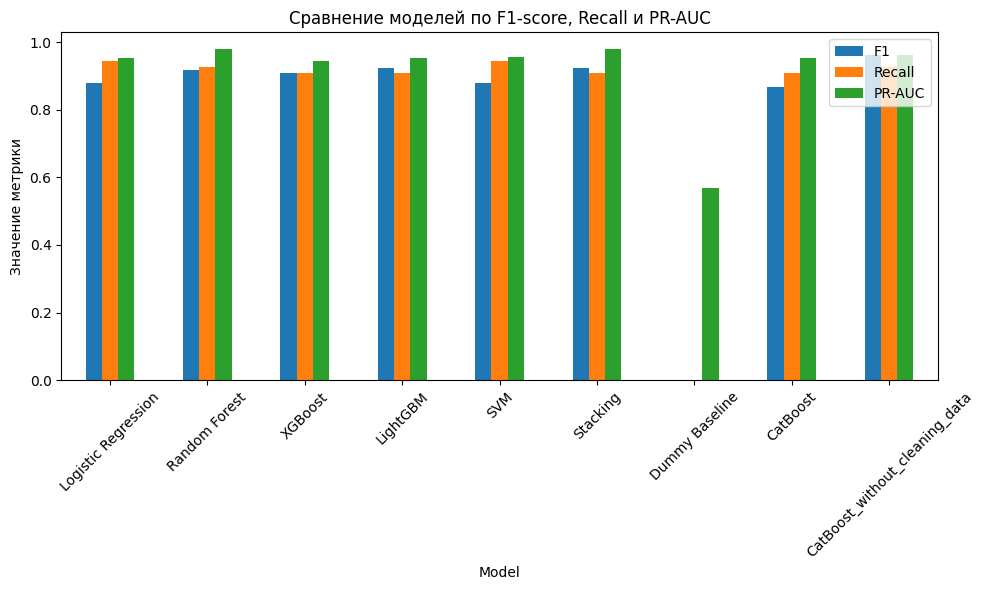

In [ ]:
import matplotlib.pyplot as plt
results_df.set_index('Model')[['F1', 'Recall', 'PR-AUC']].plot(kind='bar', figsize=(10, 6))
plt.title('Сравнение моделей по F1-score, Recall и PR-AUC')
plt.ylabel('Значение метрики')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

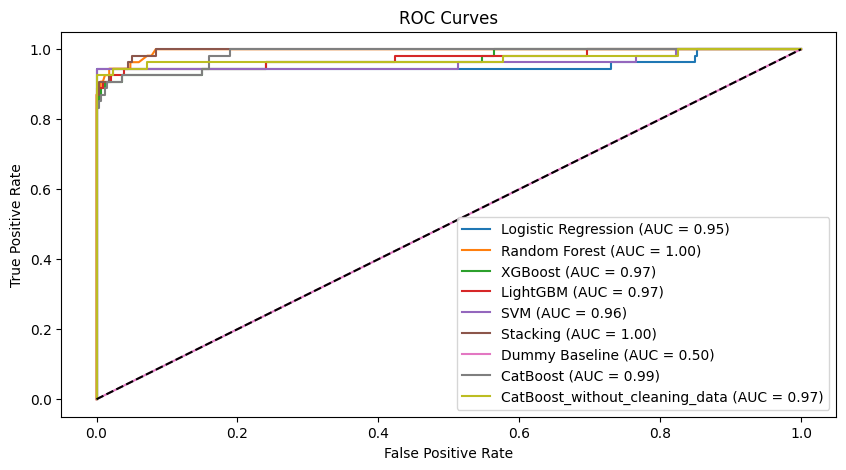

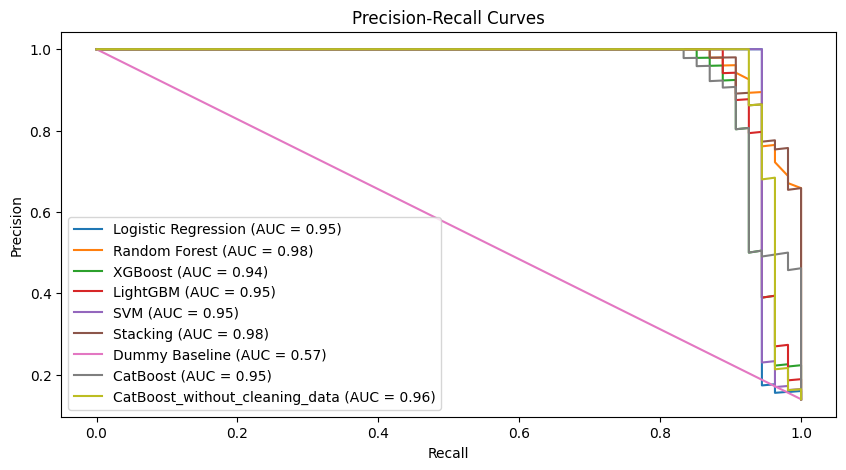

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Построение ROC-кривых
plt.figure(figsize=(10, 5))
for name, data in models_data.items():
    model = data['model']
    X_test_ROC = data['X_test']
    y_test_ROC = data['y_test']
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_ROC)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_ROC, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Построение Precision-Recall-кривых
plt.figure(figsize=(10, 5))
for name, data in models_data.items():
    model = data['model']
    X_test_ROC = data['X_test']
    y_test_ROC = data['y_test']
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_ROC)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test_ROC, y_pred_proba)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


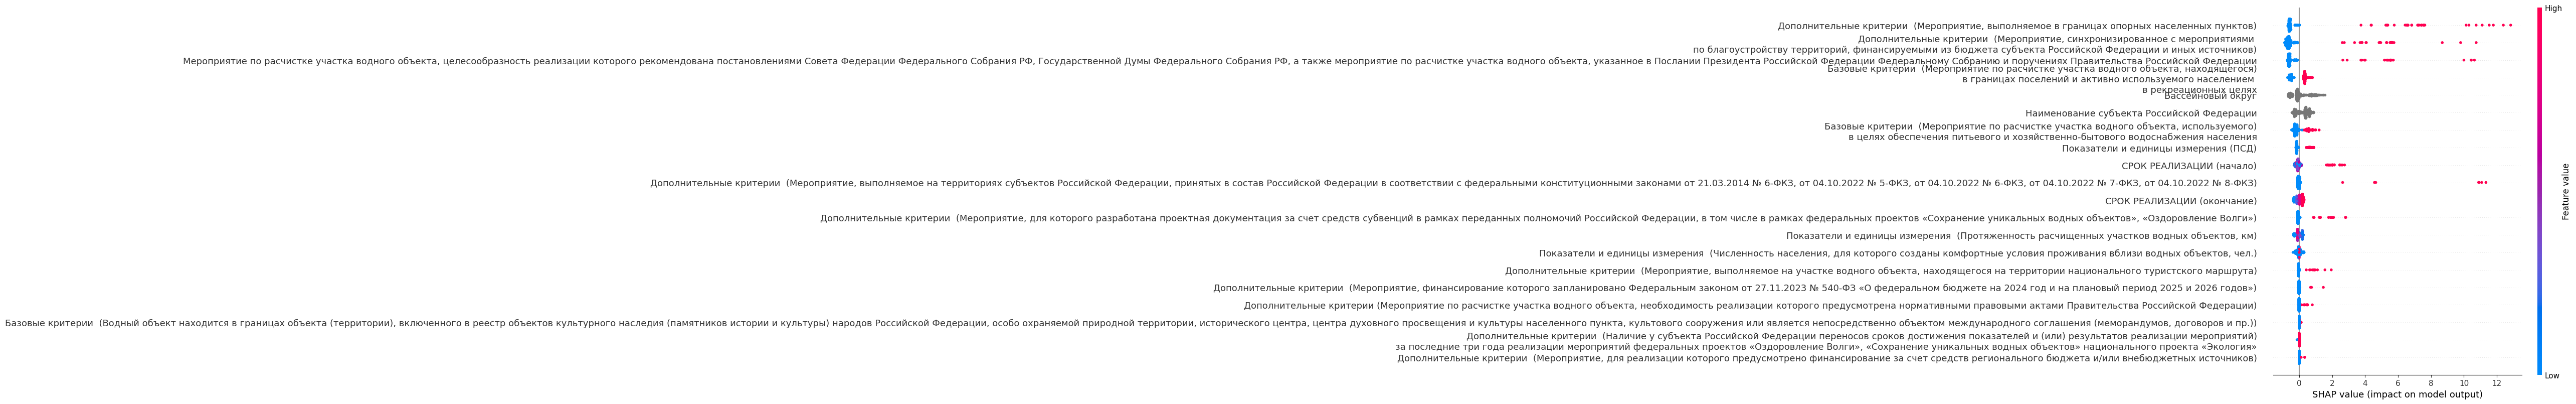

In [ ]:
import shap
explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(X_test2)
shap.summary_plot(shap_values, X_test2)

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


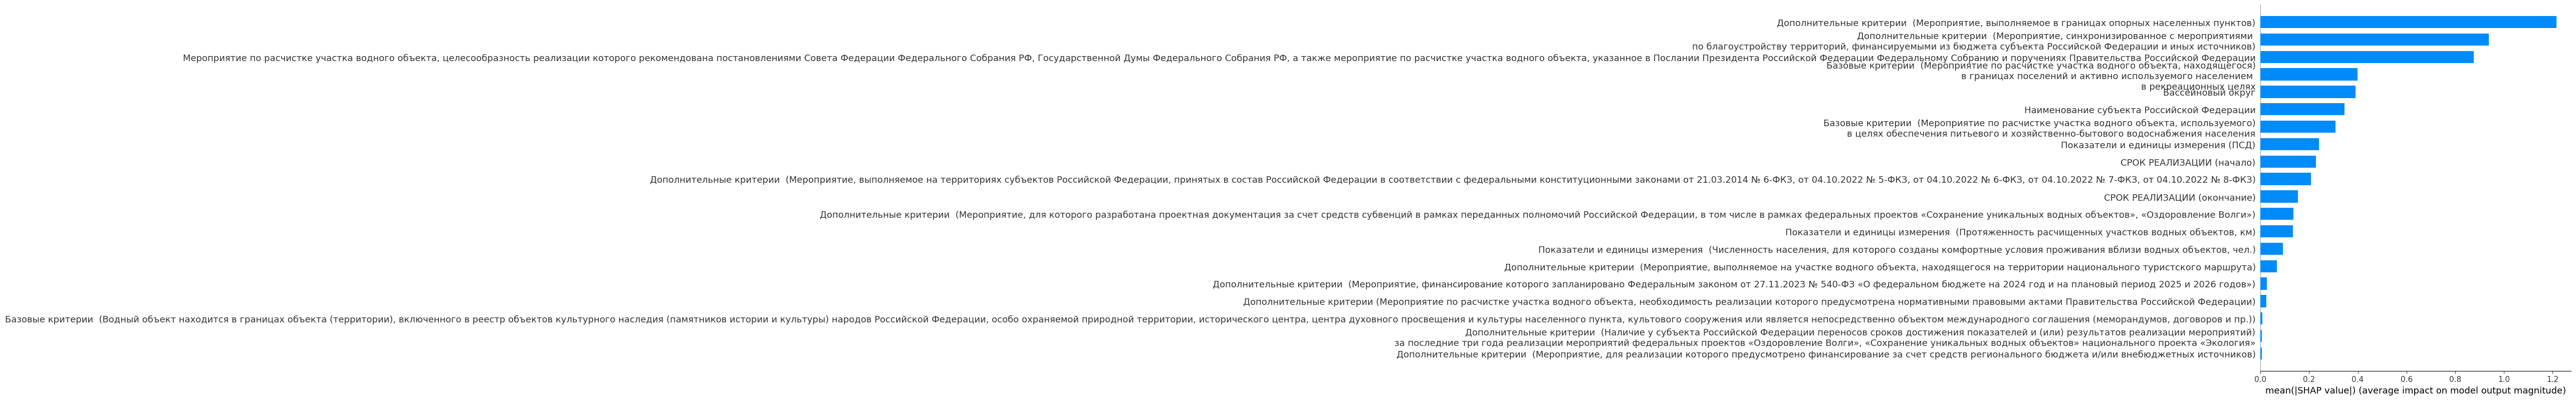

In [ ]:
shap.summary_plot(shap_values, X_test2, plot_type="bar")

# ПРОВЕРКА НА ПЕРЕОБУЧЕНИЕ

Если разница между метриками на train и test большая (например, >10–15%), это признак переобучения.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, matthews_corrcoef, balanced_accuracy_score
import pandas as pd

# Функция для тренировочной выборки
def evaluate_model_on_train(model, X_train, y_train, model_name):
    # Проверка на соответствие размеров
    if len(X_train) != len(y_train):
        raise ValueError(f"Inconsistent number of samples: X_train ({len(X_train)}) vs y_train ({len(y_train)})")

    y_pred = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    balanced_acc = balanced_accuracy_score(y_train, y_pred)
    mcc = matthews_corrcoef(y_train, y_pred)

    roc_auc = roc_auc_score(y_train, y_pred_proba) if y_pred_proba is not None else None
    precision_vals, recall_vals, _ = precision_recall_curve(y_train, y_pred_proba) if y_pred_proba is not None else (None, None, None)
    pr_auc = auc(recall_vals, precision_vals) if y_pred_proba is not None else None

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Balanced Accuracy': balanced_acc,
        'MCC': mcc,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc
    }

# Функция для тестовой выборки
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba) if y_pred_proba is not None else (None, None, None)
    pr_auc = auc(recall_vals, precision_vals) if y_pred_proba is not None else None

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Balanced Accuracy': balanced_acc,
        'MCC': mcc,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc
    }

# Обновлённый словарь моделей
models_data = {
    'Logistic Regression': {
        'model': best_logreg,
        'X_train': X_train_balanced,
        'y_train': y_train_balanced,
        'X_test': X_test,
        'y_test': y_test
    },
    'Random Forest': {
        'model': best_rf,
        'X_train': X_train_balanced,
        'y_train': y_train_balanced,
        'X_test': X_test,
        'y_test': y_test
    },
    'XGBoost': {
        'model': best_xgb,
        'X_train': X_train_balanced,
        'y_train': y_train_balanced,
        'X_test': X_test,
        'y_test': y_test
    },
    'LightGBM': {
        'model': best_lgbm,
        'X_train': X_train_balanced,
        'y_train': y_train_balanced,
        'X_test': X_test,
        'y_test': y_test
    },
    'SVM': {
        'model': best_svm,
        'X_train': X_train_balanced,
        'y_train': y_train_balanced,
        'X_test': X_test,
        'y_test': y_test
    },
    'Stacking': {
        'model': stacking,
        'X_train': X_train_balanced,
        'y_train': y_train_balanced,
        'X_test': X_test,
        'y_test': y_test
    },
    'Dummy Baseline': {
        'model': dummy,
        'X_train': X_train_balanced,
        'y_train': y_train_balanced,
        'X_test': X_test,
        'y_test': y_test
    },
    'CatBoost': {
        'model': model1,
        'X_train': X_train_balanced,
        'y_train': y_train_balanced,
        'X_test': X_test,
        'y_test': y_test
    },
    'CatBoost_without_cleaning_data': {
        'model': model2,
        'X_train': X_train2,  # Данные без SMOTE
        'y_train': y_train2,  # Соответствующий y_train
        'X_test': X_test2,
        'y_test': y_test2
    }
}

# Сравнение метрик
results_train = []
results_test = []
for name, data in models_data.items():
    # Метрики на тренировочной выборке
    print(f"\nОценка модели {name} на тренировочной выборке")
    result_train = evaluate_model_on_train(data['model'], data['X_train'], data['y_train'], name)
    results_train.append(result_train)

    # Метрики на тестовой выборке
    print(f"Оценка модели {name} на тестовой выборке")
    result_test = evaluate_model(data['model'], data['X_test'], data['y_test'], name)
    results_test.append(result_test)

# Преобразование в DataFrame
results_train_df = pd.DataFrame(results_train)
results_test_df = pd.DataFrame(results_test)

# Сравнение F1-score
comparison_df = pd.DataFrame({
    'Model': results_train_df['Model'],
    'F1_Train': results_train_df['F1'].round(4),
    'F1_Test': results_test_df['F1'].round(4),
    'Difference': (results_train_df['F1'] - results_test_df['F1']).round(4)
})

print("\nСравнение F1-score между Train и Test:")
print(comparison_df.to_markdown(index=False))

# Проверка на переобучение
for index, row in comparison_df.iterrows():
    if row['Difference'] > 0.15:  # Пороговое значение для разницы
        print(f"Модель {row['Model']} может быть переобучена: F1_Train ({row['F1_Train']}) - F1_Test ({row['F1_Test']}) = {row['Difference']}")


Оценка модели Logistic Regression на тренировочной выборке
Оценка модели Logistic Regression на тестовой выборке

Оценка модели Random Forest на тренировочной выборке
Оценка модели Random Forest на тестовой выборке

Оценка модели XGBoost на тренировочной выборке
Оценка модели XGBoost на тестовой выборке

Оценка модели LightGBM на тренировочной выборке
Оценка модели LightGBM на тестовой выборке

Оценка модели SVM на тренировочной выборке
Оценка модели SVM на тестовой выборке

Оценка модели Stacking на тренировочной выборке
Оценка модели Stacking на тестовой выборке

Оценка модели Dummy Baseline на тренировочной выборке
Оценка модели Dummy Baseline на тестовой выборке

Оценка модели CatBoost на тренировочной выборке
Оценка модели CatBoost на тестовой выборке

Оценка модели CatBoost_without_cleaning_data на тренировочной выборке
Оценка модели CatBoost_without_cleaning_data на тестовой выборке

Сравнение F1-score между Train и Test:
| Model                          |   F1_Train |   F1_Tes

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Если средний F1-score на кросс-валидации значительно ниже, чем на полной тренировочной выборке, это указывает на переобучение.
Большая дисперсия (высокое значение +/-) также может быть признаком нестабильности модели.

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Кросс-валидация для каждой модели
for name, data in models_data.items():
    model = data['model']
    X = data['X_train']  # Тренировочные данные (X_train_balanced или X_train2)
    y = data['y_train']  # Соответствующий y_train (y_train_balanced или y_train2)

    # Проверка размеров
    if len(X) != len(y):
        raise ValueError(f"Inconsistent number of samples for {name}: X_train ({len(X)}) vs y_train ({len(y)})")

    # Кросс-валидация
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1', n_jobs=-1)

    # Вывод результатов кросс-валидации
    print(f"\nКросс-валидация для {name}:")
    print(f"F1-scores: {np.round(cv_scores, 4)}")
    print(f"Mean F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Сравнение с F1 на тренировочной выборке
    train_f1 = results_train_df[results_train_df['Model'] == name]['F1'].values[0]
    print(f"F1 на тренировочной выборке: {train_f1:.4f}")

    # Проверка на переобучение
    if (train_f1 - cv_scores.mean()) > 0.15:
        print(f"Модель {name} может быть переобучена: разница между F1 на тренировочной выборке и кросс-валидацией = {(train_f1 - cv_scores.mean()):.4f}")


Кросс-валидация для Logistic Regression:
F1-scores: [0.987  0.9505 0.9351 0.9178 0.9474]
Mean F1: 0.9475 (+/- 0.0457)
F1 на тренировочной выборке: 0.9506

Кросс-валидация для Random Forest:
F1-scores: [0.9871 0.987  0.9808 0.9871 0.9744]
Mean F1: 0.9833 (+/- 0.0102)
F1 на тренировочной выборке: 1.0000

Кросс-валидация для XGBoost:
F1-scores: [0.9871 0.9903 0.9808 0.987  0.9712]
Mean F1: 0.9833 (+/- 0.0135)
F1 на тренировочной выборке: 1.0000

Кросс-валидация для LightGBM:
F1-scores: [0.9903 0.9935 0.984  0.9903 0.9709]
Mean F1: 0.9858 (+/- 0.0161)
F1 на тренировочной выборке: 1.0000

Кросс-валидация для SVM:
F1-scores: [0.9838 0.9539 0.9281 0.9215 0.9342]
Mean F1: 0.9443 (+/- 0.0451)
F1 на тренировочной выборке: 0.9494

Кросс-валидация для Stacking:
F1-scores: [0.9903 0.9902 0.984  0.9903 0.9744]
Mean F1: 0.9858 (+/- 0.0125)
F1 на тренировочной выборке: 1.0000

Кросс-валидация для Dummy Baseline:
F1-scores: [0.     0.6652 0.6652 0.     0.    ]
Mean F1: 0.2661 (+/- 0.6518)
F1 на тренир

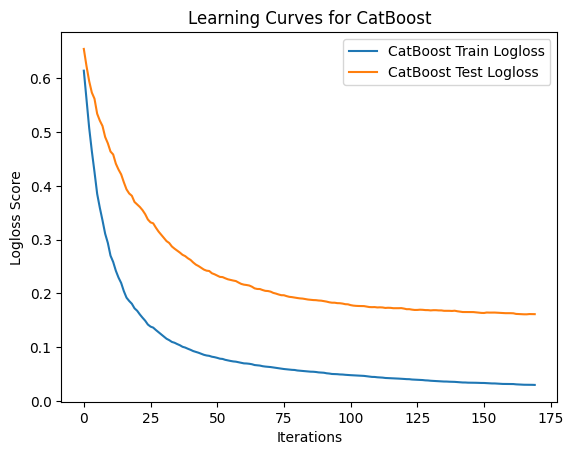

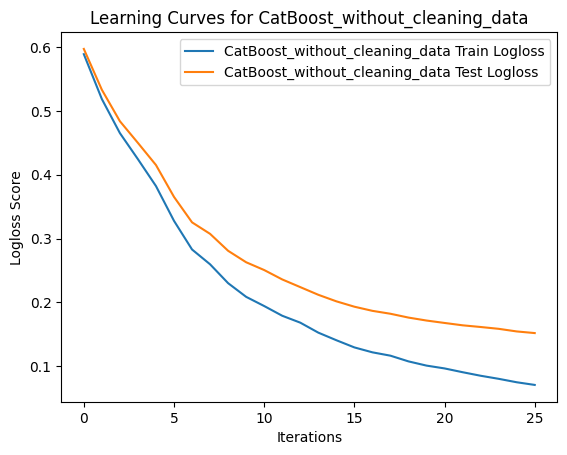

In [ ]:
import matplotlib.pyplot as plt

# Построение кривых обучения для моделей CatBoost
for name, data in models_data.items():
    if 'CatBoost' in name:  # Применяем только к CatBoost
        model = data['model']
        X_train = data['X_train']  # X_train_balanced или X_train2
        y_train = data['y_train']  # y_train_balanced или y_train2
        X_test = data['X_test']    # X_test или X_test2
        y_test = y_test            # Одинаковый y_test для всех моделей

        # Проверка размеров
        if len(X_train) != len(y_train):
            raise ValueError(f"Inconsistent number of samples for {name}: X_train ({len(X_train)}) vs y_train ({len(y_train)})")
        if len(X_test) != len(y_test):
            raise ValueError(f"Inconsistent number of samples for {name}: X_test ({len(X_test)}) vs y_test ({len(y_test)})")

        # Переобучение модели с валидационной выборкой
        # Указываем метрику F1 через custom_metric, так как eval_metric задаётся при инициализации
        model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=0,
                  early_stopping_rounds=20)

        # Получение метрик
        # CatBoost возвращает метрики, указанные в custom_metric, через get_evals_result()
        # Если при инициализации модели не был задан custom_metric='F1', используем 'Logloss' по умолчанию
        train_metrics = model.get_evals_result()['learn']
        test_metrics = model.get_evals_result()['validation']

        # Проверяем, есть ли F1 в метриках
        metric_name = 'F1' if 'F1' in train_metrics else 'Logloss'  # Если F1 нет, используем Logloss
        train_metric = train_metrics[metric_name]
        test_metric = test_metrics[metric_name]

        # Построение кривых
        plt.plot(train_metric, label=f'{name} Train {metric_name}')
        plt.plot(test_metric, label=f'{name} Test {metric_name}')
        plt.xlabel('Iterations')
        plt.ylabel(f'{metric_name} Score')
        plt.title(f'Learning Curves for {name}')
        plt.legend()
        plt.show()

Обе кривые (Train и Test) уменьшаются в начале, что указывает на улучшение модели.
После примерно 100 итераций Train Logloss продолжает снижаться до 0.1, тогда как Test Logloss перестаёт улучшаться и стабилизируется около 0.2.
Признак переобучения: Разрыв между Train Logloss и Test Logloss увеличивается после 100 итераций. Модель продолжает лучше обучаться на тренировочных данных, но не обобщает это улучшение на тестовые данные. Это классический признак переобучения.
Вывод: Модель CatBoost переобучается после ~100 итераций. Рекомендуется использовать early_stopping_rounds (например, 20) или ограничить число итераций до 100, где Test Logloss достигает плато.

Обе кривые уменьшаются в начале, что указывает на обучение модели.
После примерно 15 итераций Test Logloss перестаёт улучшаться и стабилизируется около 0.2, тогда как Train Logloss продолжает снижаться до 0.1 к 25 итерациям.
Признак переобучения: Разрыв между Train Logloss и Test Logloss увеличивается после 15 итераций. Модель лучше обучается на тренировочных данных, но не улучшает результаты на тестовых данных после этой точки.
Вывод: Модель CatBoost_without_cleaning_data переобучается после ~15 итераций. Рекомендуется ограничить число итераций до 15 или настроить early_stopping_rounds для остановки в этой точке.

# Написание кода нейронной сети:

In [ ]:
data_3 = pd.read_excel('/content/drive/MyDrive/ранжирование мероприятий/Сводный перечень (1).xlsx', sheet_name='Датасет')

удаляю нулевую строку

In [ ]:
data_3 = data_3.drop([0])

Удален "Суммарный балл по мероприятию" потому что не нужен

In [ ]:
data_3 = data_3.drop(['Суммарный балл по мероприятию'], axis=1)
data_3 = data_3.fillna(0)
data_3 = data_3.astype({'СРОК РЕАЛИЗАЦИИ (начало)': 'int',
                'СРОК РЕАЛИЗАЦИИ (окончание)': 'int',
                  'Профинансировано': int})

<ipython-input-420-c37e2ca905aa>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_3 = data_3.fillna(0)


In [ ]:
data_3

,Бассейновый округ,Наименование субъекта Российской Федерации,Наименование мероприятия,СРОК РЕАЛИЗАЦИИ (начало),СРОК РЕАЛИЗАЦИИ (окончание),"Базовые критерии (Водный объект находится в границах объекта (территории), включенного в реестр объектов культурного наследия (памятников истории и культуры) народов Российской Федерации, особо охраняемой природной территории, исторического центра, центра духовного просвещения и культуры населенного пункта, культового сооружения или является непосредственно объектом международного соглашения (меморандумов, договоров и пр.))","Базовые критерии (Мероприятие по расчистке участка водного объекта, используемого)\nв целях обеспечения питьевого и хозяйственно-бытового водоснабжения населения","Базовые критерии (Мероприятие по расчистке участка водного объекта, находящегося)\nв границах поселений и активно используемого населением \nв рекреационных целях","Дополнительные критерии (Мероприятие, синхронизированное с мероприятиями \nпо благоустройству территорий, финансируемыми из бюджета субъекта Российской Федерации и иных источников)",Дополнительные критерии Мероприятие по реализации нового этапа ранее начатого мероприятия на водном объекте (в случае наличия у мероприятия заключенного государственного контракта балл увеличивается в 2 раза)),...,"Дополнительные критерии (Мероприятие, включенное в долгосрочные планы комплексного социально-экономического развития городов Дальнего Востока)","Дополнительные критерии (Мероприятие, выполняемое на территории Арктической зоны Российской Федерации)","Дополнительные критерии (Мероприятие, выполняемое на участке водного объекта, находящегося на территории национального туристского маршрута)","Дополнительные критерии (Мероприятие, выполняемое в границах опорных населенных пунктов)","Дополнительные критерии (Мероприятие, для реализации которого предусмотрено финансирование за счет средств регионального бюджета и/или внебюджетных источников)","Дополнительные критерии (Наличие у субъекта Российской Федерации переносов сроков достижения показателей и (или) результатов реализации мероприятий)\nза последние три года реализации мероприятий федеральных проектов «Оздоровление Волги», «Сохранение уникальных водных объектов» национального проекта «Экология»",Показатели и единицы измерения (ПСД),"Показатели и единицы измерения (Протяженность расчищенных участков водных объектов, км)","Показатели и единицы измерения (Численность населения, для которого созданы комфортные условия проживания вблизи водных объектов, чел.)",Профинансировано
1,Уральский БО,Оренбургская область,Расчитка русла реки Урал на территории города ...,2025,2027,0,0,1,4,0,...,0,0,2,2,0,0,0.0,5.80,449367.0,1
2,Донской БО,Ростовская область,Расчистка б. Темерник (б. Камышеваха) от впад...,2025,2025,1,0,1,4,10,...,0,0,2,2,0,0,0.0,3.60,78583.0,1
3,Иртышский БО,Курганская область,Расчистка Курганского водохранилища в городе К...,2025,2026,0,1,1,4,10,...,0,0,0,2,0,0,0.0,1.50,254587.0,1
4,Камский БО,Республика Татарстан,Расчистка участка р.Мелекеска в г.Набережные Ч...,2025,2027,0,0,1,4,0,...,0,0,0,2,0,0,0.0,2.60,442975.0,1
5,Иртышский БО,Тюменская область,Расчистка озера Алебашево в городе Тюмень,2025,2026,0,0,1,4,10,...,0,0,0,2,0,0,0.0,2.24,861098.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,Западно-Каспийский БО,Республика Северная Осетия - Алания,Расчистка рыбопропускного сооружения на головн...,2025,2025,0,0,1,0,0,...,0,0,0,0,0,-1,1.0,3.50,0.0,0
1284,Западно-Каспийский БО,Республика Северная Осетия - Алания,"Расчистка русла реки ""Собачья балка"" от г.Влад...",2025,2025,0,0,1,0,0,...,0,0,0,0,0,-1,1.0,7.30,1970.0,0
1285,Днепровский БО,Брянская область,Расчистка пруда Негинского на территории Невдо...,2030,2030,0,0,1,0,0,...,0,0,0,0,0,-1,0.0,0.00,700.0,0
1286,Днепровский БО,Брянская область,Расчистка пруда на р. Унеча по ул. Ленина в Ун...,2029,2029,0,1,0,0,0,...,0,0,0,0,0,-1,0.0,22.00,20000.0,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
data_3.iloc[:, 5:-1 ] = scaler.fit_transform(data_3.iloc[:, 5:-1 ])

<ipython-input-424-808292fe4f88>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 1. 1. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_3.iloc[:, 5:-1 ] = scaler.fit_transform(data_3.iloc[:, 5:-1 ])


In [ ]:
label_encoder = LabelEncoder()

In [ ]:
data_3['Бассейновый округ'] = label_encoder.fit_transform(data_3['Бассейновый округ'])

In [ ]:
data_3['Наименование субъекта Российской Федерации'] = label_encoder.fit_transform(data_3['Наименование субъекта Российской Федерации'])

In [ ]:
data_3['Наименование мероприятия'] = label_encoder.fit_transform(data_3['Наименование мероприятия'])

обработка выбросов, с помощью логарифмирования

In [ ]:
data_3['Показатели и единицы измерения  (Численность населения, для которого созданы комфортные условия проживания вблизи водных объектов, чел.)'] = np.log1p(data_3['Показатели и единицы измерения  (Численность населения, для которого созданы комфортные условия проживания вблизи водных объектов, чел.)'])

In [ ]:
data_3 = data_3.drop(columns = ['Наименование мероприятия'])

In [ ]:
X3 = data_3.drop('Профинансировано', axis=1)
y3 = data_3['Профинансировано']

In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X3, y3, test_size=0.3, stratify=y, random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_balanced3, y_train_balanced3= smote.fit_resample(X_train3, y_train3)

In [ ]:
X_train3.shape, y_train3.shape

((900, 24), (900,))

In [ ]:
y_train3.value_counts()

,count
Профинансировано,
0,773
1,127


In [ ]:
!pip install torchmetrics

In [ ]:
import torchvision
from sklearn.datasets import make_regression, make_classification
import torch as th
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

In [ ]:
Y_test_tensor = th.tensor(y_test3.values, dtype=th.float64).reshape(-1, 1)
X_train_tensor = th.tensor(X_train3.values, dtype=th.float64)
X_test_tensor = th.tensor(X_test3.values, dtype=th.float64)
Y_train_tensor = th.tensor(y_train3.values, dtype=th.float64).reshape(-1, 1)

In [ ]:
dataset = TensorDataset(X_train_tensor, Y_train_tensor)
data22 = DataLoader(dataset, batch_size = 10)

Epoch [0/500], Loss: 56.9841, Accuracy: 0.4871
Epoch [5/500], Loss: 25.6079, Accuracy: 0.5181
Epoch [10/500], Loss: 16.3496, Accuracy: 0.5142
Epoch [15/500], Loss: 10.2310, Accuracy: 0.4864
Epoch [20/500], Loss: 6.4388, Accuracy: 0.5201
Epoch [25/500], Loss: 4.1992, Accuracy: 0.5058
Epoch [30/500], Loss: 2.8472, Accuracy: 0.4884
Epoch [35/500], Loss: 1.9538, Accuracy: 0.5175
Epoch [40/500], Loss: 1.5018, Accuracy: 0.5006
Epoch [45/500], Loss: 1.3872, Accuracy: 0.4994
Epoch [50/500], Loss: 1.1804, Accuracy: 0.4851
Epoch [55/500], Loss: 1.0385, Accuracy: 0.4754
Epoch [60/500], Loss: 0.9432, Accuracy: 0.4929
Epoch [65/500], Loss: 0.8735, Accuracy: 0.4948
Epoch [70/500], Loss: 0.8135, Accuracy: 0.5123
Epoch [75/500], Loss: 0.7905, Accuracy: 0.4851
Epoch [80/500], Loss: 0.7990, Accuracy: 0.5000
Epoch [85/500], Loss: 0.7847, Accuracy: 0.4864
Epoch [90/500], Loss: 0.7690, Accuracy: 0.4858
Epoch [95/500], Loss: 0.7294, Accuracy: 0.5123
Epoch [100/500], Loss: 0.7333, Accuracy: 0.4832
Epoch [105

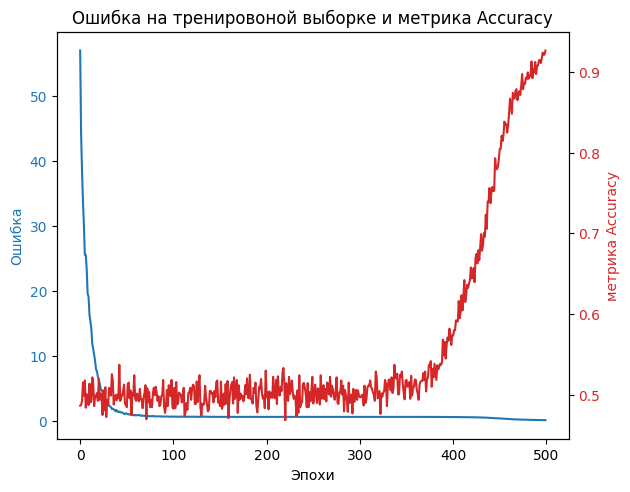

Предсказанные значения: [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 

In [ ]:
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

X_train_resampled, Y_train_resampled = SMOTE().fit_resample(X_train_tensor, Y_train_tensor)

# X_train_resampled, Y_train_resampled = X_train_tensor, Y_train_tensor

X_train_tensor1 = th.tensor(X_train_resampled, dtype=th.float32)
Y_train_tensor1 = th.tensor(Y_train_resampled, dtype=th.long)

dataset = TensorDataset(X_train_tensor1, Y_train_tensor1)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size).double()  # Convert weight tensor to Double
        self.fc2 = nn.Linear(hidden_size, hidden_size).double()
        self.fc3 = nn.Linear(hidden_size, num_classes).double()
        self.dropout = nn.Dropout(0.5)

    def forward(self, X):
        out = self.fc1(X.double())  # Convert input tensor to Double
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out


input_size = X_train.shape[1]
hidden_size = 32
num_classes = 2

model = Net(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
gamma = 0.0001
# Оптимизатор Adam
optimizer = optim.Adam(model.parameters(), lr=gamma)

# num_epochs = 750
num_epochs = 500
log_interval = 5

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    epoch_losses = []
    all_preds = []
    all_labels = []

    for x, y in data_loader:
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_losses.append(loss.item())

        _, predicted = th.max(out.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(y.numpy())

    train_loss = sum(epoch_losses) / len(epoch_losses)
    train_accuracy = accuracy_score(all_labels, all_preds)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    if epoch % log_interval == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Эпохи')
ax1.set_ylabel('Ошибка', color=color)
ax1.plot(range(num_epochs), train_losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('метрика Accuracy', color=color)
ax2.plot(range(num_epochs), train_accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Ошибка на тренировоной выборке и метрика Accuracy')
plt.show()

model.eval()
with th.no_grad():
    outputs = model(X_train_tensor)
    _, predicted = th.max(outputs.data, 1)
    predictions = predicted.numpy()

print("Предсказанные значения:", predictions)

In [ ]:
import torch as th
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, matthews_corrcoef, balanced_accuracy_score
import pandas as pd

def evaluate_neural_network(model, X_data, y_data, data_name="Test"):
    """
    Оценивает метрики нейронной сети на заданных данных и выводит результаты в таблице pandas.

    Parameters:
    - model: обученная нейронная сеть (модель класса Net)
    - X_data: данные для предсказания (pandas.DataFrame или numpy.ndarray)
    - y_data: истинные метки (pandas.Series или numpy.ndarray)
    - data_name: название выборки для вывода (например, "Test" или "Train")

    Returns:
    - DataFrame с метриками
    """
    # Проверка на соответствие размеров
    if len(X_data) != len(y_data):
        raise ValueError(f"Inconsistent number of samples: X_data ({len(X_data)}) vs y_data ({len(y_data)})")

    # Перевод модели в режим оценки
    model.eval()
    try:
        with th.no_grad():
            # Преобразование данных в тензор
            X_tensor = th.tensor(X_data.values, dtype=th.float64).double()
            outputs = model(X_tensor)
            y_pred_proba = F.softmax(outputs, dim=1)[:, 1].numpy()
            y_pred = th.max(outputs, 1)[1].numpy()
    except Exception as e:
        print(f"Ошибка при оценке нейронной сети на данных {data_name}: {e}. Пропуск.")
        return None

    # Вычисление метрик
    accuracy = accuracy_score(y_data, y_pred)
    precision = precision_score(y_data, y_pred)
    recall = recall_score(y_data, y_pred)
    f1 = f1_score(y_data, y_pred)
    balanced_acc = balanced_accuracy_score(y_data, y_pred)
    mcc = matthews_corrcoef(y_data, y_pred)
    roc_auc = roc_auc_score(y_data, y_pred_proba) if y_pred_proba is not None else None
    precision_vals, recall_vals, _ = precision_recall_curve(y_data, y_pred_proba) if y_pred_proba is not None else (None, None, None)
    pr_auc = auc(recall_vals, precision_vals) if y_pred_proba is not None else None

    # Создание DataFrame с метриками
    metrics_df = pd.DataFrame({
        'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1', 'Balanced Accuracy', 'MCC', 'ROC-AUC', 'PR-AUC'],
        'Значение': [accuracy, precision, recall, f1, balanced_acc, mcc, roc_auc, pr_auc]
    })

    # Вывод таблицы
    print(f"\nМетрики нейронной сети на {data_name} выборке:")
    print(metrics_df.round(4).to_string(index=False))

    # Возвращаем DataFrame с метриками
    return metrics_df


In [ ]:
# Оценка на тренировочных данных
metrics_train_df = evaluate_neural_network(model, X_train, y_train, data_name="Train")

# Оценка на тестовых данных
metrics_test_df = evaluate_neural_network(model, X_test, y_test, data_name="Test")

# Сравнение F1-score для проверки переобучения
if metrics_train_df is not None and metrics_test_df is not None:
    f1_train = metrics_train_df[metrics_train_df['Метрика'] == 'F1']['Значение'].iloc[0]
    f1_test = metrics_test_df[metrics_test_df['Метрика'] == 'F1']['Значение'].iloc[0]
    difference = f1_train - f1_test
    print(f"\nСравнение F1-score между Train и Test:")
    print(f"F1_Train: {f1_train:.4f}, F1_Test: {f1_test:.4f}, Difference: {difference:.4f}")
    if difference > 0.15:
        print(f"Модель может быть переобучена: F1_Train ({f1_train:.4f}) - F1_Test ({f1_test:.4f}) = {difference:.4f}")
else:
    print("Не удалось вычислить метрики для одной из выборок.")


Метрики нейронной сети на Train выборке:
          Метрика  Значение
         Accuracy    0.9933
        Precision    1.0000
           Recall    0.9528
               F1    0.9758
Balanced Accuracy    0.9764
              MCC    0.9723
          ROC-AUC    0.9996
           PR-AUC    0.9980

Метрики нейронной сети на Test выборке:
          Метрика  Значение
         Accuracy    0.9793
        Precision    1.0000
           Recall    0.8519
               F1    0.9200
Balanced Accuracy    0.9259
              MCC    0.9121
          ROC-AUC    0.9964
           PR-AUC    0.9825

Сравнение F1-score между Train и Test:
F1_Train: 0.9758, F1_Test: 0.9200, Difference: 0.0558


In [ ]:
metrics_test_df

,Метрика,Значение
0,Accuracy,0.979328
1,Precision,1.000000
2,Recall,0.851852
3,F1,0.920000
4,Balanced Accuracy,0.925926
5,MCC,0.912067
6,ROC-AUC,0.996385
7,PR-AUC,0.982459


# СРАВНЕНИЕ:

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, matthews_corrcoef, balanced_accuracy_score
import pandas as pd
import torch as th
import torch.nn.functional as F

# Функция для оценки модели на тренировочной выборке
def evaluate_model_on_train(model, X_train, y_train, model_name):
    if len(X_train) != len(y_train):
        raise ValueError(f"Inconsistent number of samples: X_train ({len(X_train)}) vs y_train ({len(y_train)})")

    try:
        if hasattr(model, 'predict'):
            y_pred = model.predict(X_train)
            y_pred_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, 'predict_proba') else None
        elif hasattr(model, 'forward'):  # Для нейронной сети
            model.eval()
            with th.no_grad():
                X_tensor = th.tensor(X_train.values, dtype=th.float64).double()
                outputs = model(X_tensor)
                y_pred_proba = F.softmax(outputs, dim=1)[:, 1].numpy()
                y_pred = th.max(outputs, 1)[1].numpy()
        else:
            print(f"Модель {model_name} не поддерживает predict или forward. Пропуск.")
            return None
    except Exception as e:
        print(f"Ошибка при оценке {model_name} на тренировочных данных: {e}. Пропуск.")
        return None

    if y_pred is None or (y_pred_proba is None and 'proba' in model_name.lower()):
        return None

    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    balanced_acc = balanced_accuracy_score(y_train, y_pred)
    mcc = matthews_corrcoef(y_train, y_pred)

    roc_auc = roc_auc_score(y_train, y_pred_proba) if y_pred_proba is not None else None
    precision_vals, recall_vals, _ = precision_recall_curve(y_train, y_pred_proba) if y_pred_proba is not None else (None, None, None)
    pr_auc = auc(recall_vals, precision_vals) if y_pred_proba is not None else None

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Balanced Accuracy': balanced_acc,
        'MCC': mcc,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc
    }

# Функция для оценки модели на тестовой выборке
def evaluate_model(model, X_test, y_test, model_name):
    if len(X_test) != len(y_test):
        raise ValueError(f"Inconsistent number of samples: X_test ({len(X_test)}) vs y_test ({len(y_test)})")

    try:
        if hasattr(model, 'predict'):
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        elif hasattr(model, 'forward'):  # Для нейронной сети
            model.eval()
            with th.no_grad():
                X_tensor = th.tensor(X_test.values, dtype=th.float64).double()
                outputs = model(X_tensor)
                y_pred_proba = F.softmax(outputs, dim=1)[:, 1].numpy()
                y_pred = th.max(outputs, 1)[1].numpy()
        else:
            print(f"Модель {model_name} не поддерживает predict или forward. Пропуск.")
            return None
    except Exception as e:
        print(f"Ошибка при оценке {model_name} на тестовых данных: {e}. Пропуск.")
        return None

    if y_pred is None or (y_pred_proba is None and 'proba' in model_name.lower()):
        return None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba) if y_pred_proba is not None else (None, None, None)
    pr_auc = auc(recall_vals, precision_vals) if y_pred_proba is not None else None

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Balanced Accuracy': balanced_acc,
        'MCC': mcc,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc
    }

# Обновлённый словарь моделей
models_data = {
    'Logistic Regression': {
        'model': best_logreg,
        'X_train': X_train_balanced,
        'y_train': y_train_balanced,
        'X_test': X_test,
        'y_test': y_test
    },
    'Random Forest': {
        'model': best_rf,
        'X_train': X_train_balanced,
        'y_train': y_train_balanced,
        'X_test': X_test,
        'y_test': y_test
    },
    'XGBoost': {
        'model': best_xgb,
        'X_train': X_train_balanced,
        'y_train': y_train_balanced,
        'X_test': X_test,
        'y_test': y_test
    },
    'LightGBM': {
        'model': best_lgbm,
        'X_train': X_train_balanced,
        'y_train': y_train_balanced,
        'X_test': X_test,
        'y_test': y_test
    },
    'SVM': {
        'model': best_svm,
        'X_train': X_train_balanced,
        'y_train': y_train_balanced,
        'X_test': X_test,
        'y_test': y_test
    },
    'Stacking': {
        'model': stacking,
        'X_train': X_train_balanced,
        'y_train': y_train_balanced,
        'X_test': X_test,
        'y_test': y_test
    },
    'Dummy Baseline': {
        'model': dummy,
        'X_train': X_train_balanced,
        'y_train': y_train_balanced,
        'X_test': X_test,
        'y_test': y_test
    },
    'CatBoost': {
        'model': model,
        'X_train': X_train_balanced,
        'y_train': y_train_balanced,
        'X_test': X_test,
        'y_test': y_test
    },
    'CatBoost_without_cleaning_data': {
        'model': model2,
        'X_train': X_train2,
        'y_train': y_train2,
        'X_test': X_test2,
        'y_test': y_test2
    },
    'Neural Network': {
        'model': model,  # Нейронная сеть
        'X_train': X_train_tensor1,
        'y_train': Y_train_tensor1,
        'X_test': X_test_tensor,
        'y_test': Y_test_tensor
    }
}

# Сравнение метрик
results_train = []
results_test = []
for name, data in models_data.items():
    # Метрики на тренировочной выборке
    print(f"\nОценка модели {name} на тренировочной выборке")
    result_train = evaluate_model_on_train(data['model'], data['X_train'], data['y_train'], name)
    if result_train is not None:
        results_train.append(result_train)

    # Метрики на тестовой выборке
    print(f"Оценка модели {name} на тестовой выборке")
    result_test = evaluate_model(data['model'], data['X_test'], data['y_test'], name)
    if result_test is not None:
        results_test.append(result_test)

# Преобразование в DataFrame (только успешные результаты)
if results_train:
    results_train_df = pd.DataFrame(results_train)
else:
    results_train_df = pd.DataFrame()
    print("Нет данных для тренировочной выборки.")

if results_test:
    results_test_df = pd.DataFrame(results_test)
else:
    results_test_df = pd.DataFrame()
    print("Нет данных для тестовой выборки.")

# Сравнение F1-score (только если данные есть)
if not results_train_df.empty and not results_test_df.empty:
    comparison_df = pd.DataFrame({
        'Model': results_train_df['Model'],
        'F1_Train': results_train_df['F1'].round(4),
        'F1_Test': results_test_df['F1'].round(4),
        'Difference': (results_train_df['F1'] - results_test_df['F1']).round(4)
    })

    print("\nСравнение F1-score между Train и Test:")
    print(comparison_df.to_markdown(index=False))

    # Проверка на переобучение
    for index, row in comparison_df.iterrows():
        if row['Difference'] > 0.15:  # Пороговое значение для разницы
            print(f"Модель {row['Model']} может быть переобучена: F1_Train ({row['F1_Train']}) - F1_Test ({row['F1_Test']}) = {row['Difference']}")
else:
    print("Нет данных для сравнения F1-score.")


Оценка модели Logistic Regression на тренировочной выборке
Оценка модели Logistic Regression на тестовой выборке

Оценка модели Random Forest на тренировочной выборке
Оценка модели Random Forest на тестовой выборке

Оценка модели XGBoost на тренировочной выборке
Оценка модели XGBoost на тестовой выборке

Оценка модели LightGBM на тренировочной выборке
Оценка модели LightGBM на тестовой выборке

Оценка модели SVM на тренировочной выборке
Оценка модели SVM на тестовой выборке

Оценка модели Stacking на тренировочной выборке
Оценка модели Stacking на тестовой выборке

Оценка модели Dummy Baseline на тренировочной выборке
Оценка модели Dummy Baseline на тестовой выборке

Оценка модели CatBoost на тренировочной выборке
Оценка модели CatBoost на тестовой выборке

Оценка модели CatBoost_without_cleaning_data на тренировочной выборке
Оценка модели CatBoost_without_cleaning_data на тестовой выборке

Оценка модели Neural Network на тренировочной выборке
Ошибка при оценке Neural Network на трени

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import torch as th
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, matthews_corrcoef, balanced_accuracy_score

def evaluate_neural_network(model, X_data, y_data, data_name="Test"):
    """
    Оценивает метрики нейронной сети на заданных данных.

    Parameters:
    - model: обученная нейронная сеть (модель класса Net)
    - X_data: данные для предсказания (pandas.DataFrame или numpy.ndarray)
    - y_data: истинные метки (pandas.Series или numpy.ndarray)
    - data_name: название выборки для вывода (например, "Test" или "Train")

    Returns:
    - Словарь с метриками
    """
    # Проверка на соответствие размеров
    if len(X_data) != len(y_data):
        raise ValueError(f"Inconsistent number of samples: X_data ({len(X_data)}) vs y_data ({len(y_data)})")

    # Перевод модели в режим оценки
    model.eval()
    try:
        with th.no_grad():
            # Преобразование данных в тензор
            X_tensor = th.tensor(X_data.values, dtype=th.float64).double()
            outputs = model(X_tensor)
            y_pred_proba = F.softmax(outputs, dim=1)[:, 1].numpy()
            y_pred = th.max(outputs, 1)[1].numpy()
    except Exception as e:
        print(f"Ошибка при оценке нейронной сети на данных {data_name}: {e}. Пропуск.")
        return None

    # Вычисление метрик
    accuracy = accuracy_score(y_data, y_pred)
    precision = precision_score(y_data, y_pred)
    recall = recall_score(y_data, y_pred)
    f1 = f1_score(y_data, y_pred)
    balanced_acc = balanced_accuracy_score(y_data, y_pred)
    mcc = matthews_corrcoef(y_data, y_pred)
    roc_auc = roc_auc_score(y_data, y_pred_proba) if y_pred_proba is not None else None
    precision_vals, recall_vals, _ = precision_recall_curve(y_data, y_pred_proba) if y_pred_proba is not None else (None, None, None)
    pr_auc = auc(recall_vals, precision_vals) if y_pred_proba is not None else None

    # Вывод результатов
    print(f"\nМетрики нейронной сети на {data_name} выборке:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")

    # Возвращаем словарь с метриками
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Balanced Accuracy': balanced_acc,
        'MCC': mcc,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc
    }

In [ ]:
# Оценка на тренировочных данных
metrics_train = evaluate_neural_network(model, X_train, y_train, data_name="Train")

# Оценка на тестовых данных
metrics_test = evaluate_neural_network(model, X_test, y_test, data_name="Test")

# Сравнение F1-score для проверки переобучения
if metrics_train and metrics_test:
    f1_train = metrics_train['F1']
    f1_test = metrics_test['F1']
    difference = f1_train - f1_test
    print(f"\nСравнение F1-score между Train и Test:")
    print(f"F1_Train: {f1_train:.4f}, F1_Test: {f1_test:.4f}, Difference: {difference:.4f}")
    if difference > 0.15:
        print(f"Модель может быть переобучена: F1_Train ({f1_train:.4f}) - F1_Test ({f1_test:.4f}) = {difference:.4f}")
else:
    print("Не удалось вычислить метрики для одной из выборок.")


Метрики нейронной сети на Train выборке:
Accuracy: 0.8589
Precision: 0.0000
Recall: 0.0000
F1: 0.0000
Balanced Accuracy: 0.5000
MCC: 0.0000
ROC-AUC: 0.5026
PR-AUC: 0.1663

Метрики нейронной сети на Test выборке:
Accuracy: 0.8605
Precision: 0.0000
Recall: 0.0000
F1: 0.0000
Balanced Accuracy: 0.5000
MCC: 0.0000
ROC-AUC: 0.5072
PR-AUC: 0.1895

Сравнение F1-score между Train и Test:
F1_Train: 0.0000, F1_Test: 0.0000, Difference: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(metrics_test)

{'Accuracy': 0.9896640826873385, 'Precision': 0.9807692307692307, 'Recall': 0.9444444444444444, 'F1': 0.9622641509433962, 'Balanced Accuracy': np.float64(0.9707207207207207), 'MCC': np.float64(0.9565071768984372), 'ROC-AUC': np.float64(0.9707207207207207), 'PR-AUC': np.float64(0.9688518144028759)}


In [ ]:
import pandas as pd

# Загрузка таблицы метрик из CSV
# Замените путь на актуальный, если файл сохранен в другом месте
results_df = pd.read_csv('/content/model_comparison.csv')

# Форматирование таблицы для вывода
results_df = results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'Balanced Accuracy', 'MCC', 'ROC-AUC', 'PR-AUC']]
results_df = results_df.round(4)

# Вывод таблицы метрик
print("\nТаблица метрик всех моделей:")
print(results_df.to_markdown(index=False))

# Определение лучшей модели
# Основная метрика: F1-score
# Дополнительные метрики: Recall, PR-AUC
best_model_f1 = results_df.loc[results_df['F1'].idxmax()]
best_model_recall = results_df.loc[results_df['Recall'].idxmax()]
best_model_pr_auc = results_df.loc[results_df['PR-AUC'].idxmax()]

# Проверка, совпадает ли модель по всем трем метрикам
if (best_model_f1['Model'] == best_model_recall['Model'] == best_model_pr_auc['Model']):
    best_model = best_model_f1
    print(f"\nЛучшая модель по F1-score, Recall и PR-AUC: {best_model['Model']}")
else:
    # Если модели различаются, выбираем по F1-score, но выводим информацию
    best_model = best_model_f1
    print(f"\nЛучшая модель по F1-score: {best_model_f1['Model']} (F1 = {best_model_f1['F1']:.4f})")
    if best_model_f1['Model'] != best_model_recall['Model']:
        print(f"Лучшая модель по Recall: {best_model_recall['Model']} (Recall = {best_model_recall['Recall']:.4f})")
    if best_model_f1['Model'] != best_model_pr_auc['Model']:
        print(f"Лучшая модель по PR-AUC: {best_model_pr_auc['Model']} (PR-AUC = {best_model_pr_auc['PR-AUC']:.4f})")

# Вывод метрик лучшей модели
print("\nМетрики лучшей модели:")
print(best_model.to_frame().T.to_markdown(index=False))


Таблица метрик всех моделей:
| Model                          |   Accuracy |   Precision |   Recall |     F1 |   Balanced Accuracy |    MCC |   ROC-AUC |   PR-AUC |
|:-------------------------------|-----------:|------------:|---------:|-------:|--------------------:|-------:|----------:|---------:|
| Logistic Regression            |     0.9638 |      0.8226 |   0.9444 | 0.8793 |              0.9557 | 0.861  |    0.955  |   0.9535 |
| Random Forest                  |     0.9767 |      0.9091 |   0.9259 | 0.9174 |              0.9555 | 0.904  |    0.9957 |   0.9796 |
| XGBoost                        |     0.9742 |      0.9074 |   0.9074 | 0.9074 |              0.9462 | 0.8924 |    0.9711 |   0.9446 |
| LightGBM                       |     0.9793 |      0.9423 |   0.9074 | 0.9245 |              0.9492 | 0.9128 |    0.9735 |   0.953  |
| SVM                            |     0.9638 |      0.8226 |   0.9444 | 0.8793 |              0.9557 | 0.861  |    0.9611 |   0.9549 |
| Stacking        

In [ ]:
metrics_test_df

,Metric,Value
0,Accuracy,0.979328
1,Precision,1.000000
2,Recall,0.851852
3,F1,0.920000
4,Balanced Accuracy,0.925926
5,MCC,0.912067
6,ROC-AUC,0.996385
7,PR-AUC,0.982459


In [ ]:
print(best_model.to_frame().T.to_markdown(index=False))

| Model                          |   Accuracy |   Precision |   Recall |     F1 |   Balanced Accuracy |    MCC |   ROC-AUC |   PR-AUC |
|:-------------------------------|-----------:|------------:|---------:|-------:|--------------------:|-------:|----------:|---------:|
| CatBoost_without_cleaning_data |     0.9897 |           1 |   0.9259 | 0.9615 |               0.963 | 0.9565 |    0.9723 |   0.9615 |
